In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import inspect
import json
from pathlib import Path
from IPython.display import display, HTML
from typing import List, Dict, Tuple, Union, Optional, Any, Callable
import pickle
import json
# Machine learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             balanced_accuracy_score, log_loss,
                             mean_squared_error, make_scorer,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# Hyperparameter tuning
# import optuna
# # 1) Silence Optuna’s default trial‐completion logs
# optuna.logging.set_verbosity(optuna.logging.WARNING)      # only WARN and above
# optuna.logging.disable_default_handler()                   # remove the stderr handler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

# # --- notebook‐local patch for Python 3.10+ compatibility ---
# import collections.abc, collections, sys, six

# # 1) Make collections.Iterable available again
# collections.Iterable = collections.abc.Iterable

# # 2) Inject six under sklearn.externals so skrules can find it
# sys.modules['sklearn.externals.six'] = six
# ---------------------------------------------------------

# Now it will import without touching your global site-packages
from skrules import SkopeRules

class TqdmCallback:
    def __init__(self, total):
        self.bar = tqdm(total=total, desc="Trials", position=2, leave=False)
    def __call__(self, study, trial):
        self.bar.update(1)
    def close(self):
        self.bar.close()

# Constants

In [2]:
DATA_CSV      = "../data/df_2022_2024.csv"
OUT_DIR       = "../skope_rules"

TARGETS =  [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

LABEL_METHOD  = "fixed"         # {"fixed","rolling","dynamic"}
TWO_SIDED     = True              # detect negative spikes too ?
LABEL_MODE    = "binary_extreme"  # or "three_class"

P_HI, P_LO    = 90, 10
ROLL_WINDOW   = 24*7
K_SIGMA       = 1
POS_FLOOR = 50
POS_TOP = 150

N_SPLITS      = 2
N_TRIALS      = 30
EARLY_STOP = 35
GPU_TREE      = True

In [3]:
#Load data
data = pd.read_csv(DATA_CSV)
data.index = pd.date_range(start='2022-11-01', periods=len(data), freq='H')

data = data.loc['2023-01-01':'2023-12-31'].copy()

# Define features
features = [col for col in data.columns if col not in TARGETS]

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Helper Functions

## Create training chunks and data processing and labels

In [4]:
def get_windows(
    start: pd.Timestamp,
    end: pd.Timestamp,
    train_h: int = 7 * 7 * 24,
    test_h: int = 7 * 24
) -> List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]]:
        """
    Generate a series of (train_start, train_end, test_start, test_end) tuples
    stepping by test_h each iteration, covering [start, end].

    Parameters
    ----------
    start : pd.Timestamp
        Earliest timestamp for the first training window (e.g. first
        Monday 00:00 UTC of 2023).
    end : pd.Timestamp
        Latest timestamp by which the final test window must finish.
    train_h : int, default=1176
        Number of hours to include in each training slice.
    test_h : int, default=168
        Number of hours to include in each test slice.

    Returns
    -------
    windows : List of 4‑tuples
        Each tuple is
        (train_start, train_end, test_start, test_end)
        such that
          train_end   = train_start + train_h – 1 hour
          test_start  = train_end   + 1 hour
          test_end    = test_start  + test_h – 1 hour
        and test_end ≤ end.
    """
        windows: List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]] = []
        current_train_start = start

        while True:
            train_end = current_train_start + pd.Timedelta(hours=train_h - 1)
            test_start = train_end + pd.Timedelta(hours=1)
            test_end   = test_start + pd.Timedelta(hours=test_h - 1)

            # stop if the test window would extend beyond our data
            if test_end > end:
                break

            windows.append((current_train_start, train_end, test_start, test_end))
            # shift window forward by one test period
            current_train_start += pd.Timedelta(hours=test_h)

        return windows


In [5]:
def compute_features(
    df: pd.DataFrame,
    feat_defs: Dict[str, Callable]
) -> pd.DataFrame:
    # 1) start with only the custom features
    feats = pd.DataFrame(index=df.index)
    for name, fn in feat_defs.items():
        feats[name] = fn(df)

    # 2) now auto‐add lag-1 for every numeric column in the raw df
    #    (skip booleans & categoricals if you like; here we keep numbers only)
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        feats[f"{col}_lag1"] = df[col].shift(1)

    # 3) drop anything that isn't int/float/bool/cat before modeling
    feats = feats.select_dtypes(include=['number','bool','category'])
    return feats

In [6]:
def label_spikes(
    series: pd.Series,
    train_window: Tuple[pd.Timestamp, pd.Timestamp],
    method: str = LABEL_METHOD,
    two_sided: bool = TWO_SIDED,
    percentile_high: float = P_HI,
    percentile_low: float  = P_LO,
    roll_window: int       = ROLL_WINDOW,
    k: float               = K_SIGMA,
    pos_floor: float       = POS_TOP,
    neg_floor: float       = POS_FLOOR,
    constant_high: float = 100,
    constant_low: float = -100
) -> pd.Series:
    """
    Compute binary spike labels for `series`, with hi/lo thresholds
    derived *only* from the training window and floored at pos_floor / -neg_floor.

    ...
    """

    # 1) isolate training slice for threshold computation
    t0, t1 = train_window
    train_slice = series.loc[t0:t1]

    # 2) compute raw hi/lo
    if method == "fixed":
        hi = np.percentile(train_slice, percentile_high)
        lo = (np.percentile(train_slice, percentile_low)
              if two_sided else None)
        # inside label_spikes, right after computing hi and lo but before clipping:
        # print(f"  [DEBUG]  hi cutoff = {hi!r}")
        # if lo is not None:
        #     print(f"  [DEBUG]  lo cutoff = {lo!r}")


    elif method == "rolling":
        hi = series.rolling(roll_window, min_periods=1)\
                   .quantile(percentile_high / 100)
        lo = (series.rolling(roll_window, min_periods=1)
                    .quantile(percentile_low / 100)
              if two_sided else None)

    elif method == "dynamic":
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        hi = mu + k * sd
        lo = (mu - k * sd) if two_sided else None

    elif method == "mixed":
        fixed_hi = np.percentile(train_slice, percentile_high)
        fixed_lo = (np.percentile(train_slice, percentile_low)
                    if two_sided else None)
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        dyn_hi = mu + k * sd
        dyn_lo = (mu - k * sd) if two_sided else None
        hi = dyn_hi.where(dyn_hi > fixed_hi, fixed_hi)
        lo = (dyn_lo.where(dyn_lo < fixed_lo, fixed_lo)
              if two_sided else None)
    elif method == "constant":
        if constant_high is None:
            raise ValueError("constant_high must be provided for method 'constant'")
        hi = constant_high
        lo = constant_low if (two_sided and constant_low is not None) else None

    else:
        raise ValueError(f"Unknown labeling method: {method!r}")

    if method != "constant":
        # upper floor
        if np.isscalar(hi):
            hi = max(hi, pos_floor)
        else:
            hi = hi.clip(lower=pos_floor)
        # lower floor
        if two_sided and lo is not None:
            if np.isscalar(lo):
                lo = min(lo, -neg_floor)
            else:
                lo = lo.clip(upper=-neg_floor)
                
    # 4) label spikes purely by threshold crossings
    is_high = series.ge(hi)
    if two_sided and lo is not None:
        is_low = series.le(lo)
        labels = (is_high | is_low).astype(int)
    else:
        labels = is_high.astype(int)

    return labels


In [7]:
def train_skope_rules(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    feature_names: list[str],
    random_state: int = 42,
    n_estimators: int = 30,
    recall_min: float = 0.05,
    precision_min: float = 0.9,
    max_samples: float = 0.7,
    max_depth_duplication: int = 4,
    max_depth: int = 5,
    **kwargs: Any
) -> SkopeRules:
    """
    Train a SkopeRules classifier on (X, y) with your chosen hyperparameters.

    Parameters
    ----------
    X : pd.DataFrame
        Training features (rows aligned with y).
    y : pd.Series
        Binary spike labels (0/1).
    feature_names : list[str]
        List of column names for X, for human-readable rules.
    random_state : int
        Seed for reproducibility.
    n_estimators : int
        Number of bagged trees to generate candidate rules from.
    recall_min : float
        Minimum OOB recall threshold to keep a rule.
    precision_min : float
        Minimum OOB precision threshold to keep a rule.
    max_samples : float
        Fraction of samples to draw in each bootstrap (0 < max_samples ≤ 1).
    max_depth_duplication : int
        Maximum depth for rule extraction trees (controls rule length).
    max_depth : int
        Maximum depth of each tree (controls candidate diversity).
    **kwargs : Any
        Any additional parameters supported by SkopeRules
        (e.g. `max_rules`, `n_jobs`, etc.).

    Returns
    -------
    clf : SkopeRules
        Fitted rule-based classifier. Use
          - `clf.rules_` to inspect extracted rules,
          - `clf.score_top_rules(X_new)` for rule-index scores,
          - `clf.predict_top_rules(X_new, n_rules)` for binary preds.
    """
    clf = SkopeRules(
        feature_names=feature_names,
        random_state=random_state,
        n_estimators=n_estimators,
        recall_min=recall_min,
        precision_min=precision_min,
        max_samples=max_samples,
        max_depth_duplication=max_depth_duplication,
        max_depth=max_depth,
        **kwargs
    )
    # fit accepts either DataFrame or array
    clf.fit(X, y)
    return clf

In [8]:

def evaluate_skope_rules(
    model: SkopeRules,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    n_rules: Optional[int] = None
) -> Dict[str, Any]:
    """
    Same as evaluate_skope_rules, but with extra prints for debugging,
    and now also returns the Matthews correlation coefficient (mcc).
    """
    # 2) Compute continuous score
    try:
        y_score = model.decision_function(X_test.values)
    except Exception:
        y_score = model.score_top_rules(X_test.values).astype(float)

    # 3) Determine top-N
    total_rules = len(model.rules_)
    use_n = n_rules if (n_rules is not None and n_rules <= total_rules) else total_rules

    # 4) Hard predictions
    y_pred = model.predict_top_rules(X_test.values, use_n)

    # 5) Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred, zero_division=0)
    f1        = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_score)
    except Exception:
        auc = np.nan
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics = {
        "precision": precision,
        "recall":    recall,
        "f1":        f1,
        "auc":       auc,
        "mcc":       mcc,
        "confusion_matrix": cm
    }

    # 6) Build rules rows with print checks
    rows = []
    if isinstance(model.rules_, dict):
        for idx, (rule, stats) in enumerate(model.rules_.items()):
            rows.append((rule, stats[0], stats[1], stats[2]))
            if idx == 2: break
    else:
        for idx, entry in enumerate(model.rules_):
            if isinstance(entry, tuple) and len(entry) == 4:
                rule, prec, rec, supp = entry
            elif isinstance(entry, tuple) and len(entry) == 2:
                rule, stats = entry
                prec, rec, supp = stats
            else:
                continue
            rows.append((rule, prec, rec, supp))
            if idx == 2: break

    # 7) Assemble DataFrame
    rules_df = pd.DataFrame(rows, columns=["rule", "precision", "recall", "support"])

    return {
        "metrics": metrics,
        "rules":   rules_df,
        "y_score": y_score,
        "y_pred":  y_pred
    }

In [9]:
import joblib

def save_model(
    model: SkopeRules,
    metrics: dict,
    rules: pd.DataFrame,
    output_dir: str,
    *,
    regime: str = "static",     # "static" or "rolling"
    target: str,
    fold_idx: int = None,
    timestamps: tuple = None,
    y_test: pd.Series = None,
    y_score: np.ndarray = None,
    n_bins: int = 10
) -> None:
    """
    Save a trained SkopeRules model, its metrics (including optional 'mcc'),
    its rule‐set, and optional diagnostic plots (ROC, PR, Reliability).

    Parameters
    ----------
    model : SkopeRules
    metrics : dict of JSON‐serializable metrics; may include:
        - precision, recall, f1, auc
        - mcc (Matthews correlation coefficient)
        - confusion_matrix (array)
    rules : pd.DataFrame with columns [rule, precision, recall, support]
    output_dir : str, base directory
    regime : {"static","rolling"}
    target : str, target series name
    fold_idx : int, fold number if rolling
    timestamps : tuple of train/test window timestamps
    y_test : pd.Series, true labels for plotting
    y_score : array‐like, continuous scores for plotting
    n_bins : int, number of bins for calibration curve
    """
    # 1) Build path
    base = Path(output_dir)
    if regime == "static":
        subdir = base / "static" / target
    else:
        subdir = base / "rolling" / f"fold_{fold_idx}" / target
    subdir.mkdir(parents=True, exist_ok=True)

    # 2) Save the model
    joblib.dump(model, subdir / "model.pkl")

    # 3) JSON‐serialize metrics (including mcc if present)
    serial = {}
    for k, v in metrics.items():
        # numpy arrays / matrices → lists; scalars pass through
        serial[k] = v.tolist() if hasattr(v, "tolist") else v

    info = {
        "regime":  regime,
        "target":  target,
        "metrics": serial
    }
    if regime == "rolling" and timestamps:
        t0, t1, s0, s1 = timestamps
        info["train_window"] = [str(t0), str(t1)]
        info["test_window"]  = [str(s0), str(s1)]
    with open(subdir / "metrics.json", "w") as f:
        json.dump(info, f, indent=2)

    # 4) Save rules
    rules.to_csv(subdir / "extracted_rules.csv", index=False)

    # 5) If provided, plot diagnostics
    if y_test is not None and y_score is not None:
        # Normalize scores to [0,1] if needed
        y_prob = y_score
        if y_prob.min() < 0 or y_prob.max() > 1:
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1], [0,1], "--", color="grey")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {target}")
        plt.legend()
        plt.savefig(subdir / "roc_curve.png")
        plt.close()

        # Precision-Recall Curve
        prec, rec, _ = precision_recall_curve(y_test, y_score)
        plt.figure()
        plt.plot(rec, prec, label="PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve — {target}")
        plt.legend()
        plt.savefig(subdir / "pr_curve.png")
        plt.close()

        # Reliability Curve
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=n_bins)
        plt.figure()
        plt.plot(prob_pred, prob_true, marker="o", label="Reliability")
        plt.plot([0,1], [0,1], "--", color="grey", label="Ideal")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Reliability Curve — {target}")
        plt.legend()
        plt.savefig(subdir / "reliability_curve.png")
        plt.close()

In [10]:
def make_identity_feats(df: pd.DataFrame, exclude: List[str]) -> Dict[str, Callable]:
    return {
        col: (lambda c: lambda df: df[c])(col)
        for col in df.columns
        if col not in exclude
    }

In [11]:
def run_walk_forward_skope(
    data: pd.DataFrame,
    targets: List[str],
    features: List[str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    output_dir: str = "reports",
    skope_params: dict = None,
    n_jobs: int = -1,
    seed: int = 42
) -> None:
    """
    Perform walk-forward training and evaluation using Skope-Rules.

    Parameters
    ----------
    data : pd.DataFrame
        Raw time-indexed DataFrame containing target price series and feature columns.
    targets : List[str]
        List of the four price target column names.
    features : List[str]
        List of feature column names to use for modeling.
    start : pd.Timestamp
        Start timestamp for the first training window.
    end : pd.Timestamp
        End timestamp by which the final test window must finish.
    output_dir : str
        Base directory in which to save fold artifacts.
    skope_params : dict
        Hyperparameters for SkopeRules (e.g., n_estimators, precision_min, recall_min, max_depth_duplication, max_depth, max_samples, n_jobs).
    n_jobs : int
        Number of parallel jobs for rule extraction.
    seed : int
        Base random seed for reproducibility; fold index will be added for variation.
    """
    # Prepare output directory
    base_out = Path(output_dir) / "rolling"
    base_out.mkdir(parents=True, exist_ok=True)

    # Generate rolling windows
    windows: List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]] = \
        get_windows(start=start, end=end)

    # Iterate folds
    for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
        print(f"Fold {fold_idx}: train {t0}–{t1}, test {s0}–{s1}")

        # Extract raw slice covering train+test
        raw = data.loc[t0:s1]

        # Compute features
        feat_defs = make_identity_feats(raw, exclude=targets)
        X_all = compute_features(raw, feat_defs)

        # Loop targets
        for tgt in targets:
            # Label spikes based on the train window for this target
            y_all = label_spikes(
                series=data[tgt],
                train_window=(t0, t1),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )

            # Split into train/test
            X_tr = X_all.loc[t0:t1, features]
            X_te = X_all.loc[s0:s1, features]
            y_tr = y_all.loc[t0:t1]
            y_te = y_all.loc[s0:s1]

            # Train Skope-Rules model
            params = skope_params.copy() if skope_params is not None else {}
            params.update({"n_jobs": n_jobs})
            clf = train_skope_rules(
                X_tr, y_tr,
                **params,
                seed=seed + fold_idx
            )

            # Evaluate
            results = evaluate_skope_rules(clf, X_te, y_te)

            # Save artifacts
            save_model(
                model=clf,
                metrics=results['metrics'],
                rules=results['rules'],
                output_dir=str(base_out),
                regime='rolling',
                target=tgt,
                fold_idx=fold_idx,
                timestamps=(t0, t1, s0, s1)
            )

            # Clean up
            del clf
            gc.collect()


In [12]:
def run_walk_forward_skope_with_optuna(
    data: pd.DataFrame,
    targets: List[str],
    features: List[str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    output_dir: str = "reports",
    n_trials: int = 20,
    seed: int = 42
) -> None:
    """
    Perform walk-forward training with per-fold Optuna tuning using SkopeRules.

    Parameters
    ----------
    data : pd.DataFrame
        Time-indexed DataFrame with target and feature columns.
    targets : List[str]
        List of four price target column names.
    features : List[str]
        Feature column names to use.
    start : pd.Timestamp
        Start of first training window.
    end : pd.Timestamp
        End by which final test window must finish.
    output_dir : str
        Directory to save per-fold artifacts.
    n_trials : int
        Number of Optuna trials per fold.
    seed : int
        Base random seed; fold index is added for variety.
    """
    base_out = Path(output_dir) / "rolling_optuna"
    base_out.mkdir(parents=True, exist_ok=True)

    # Generate walk-forward windows
    windows: List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]] = \
        get_windows(start=start, end=end)

    # TimeSeriesSplit for tuning (3 splits of 1-week test)
    tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)

    for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
        print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")

        raw = data.loc[t0:s1]
        feat_defs = make_identity_feats(raw, exclude=targets)
        X_all = compute_features(raw, feat_defs)

        for tgt in targets:
            y_all = label_spikes(
                series=data[tgt],
                train_window=(t0, t1),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )
            # Train/test split for this fold
            X_tr = X_all.loc[t0:t1, features].dropna()
            y_tr = y_all.loc[X_tr.index]
            X_te = X_all.loc[s0:s1, features].dropna()
            y_te = y_all.loc[X_te.index]

            # Optuna hyperparameter tuning
            def objective(trial):
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 30, 200),
                    'max_depth_duplication': trial.suggest_int('max_depth_duplication', 2, 5),
                    'max_depth': trial.suggest_int('max_depth', 3, 7),
                    'precision_min': trial.suggest_float('precision_min', 0.6, 0.95),
                    'recall_min': trial.suggest_float('recall_min', 0.01, 0.1),
                    'max_samples': trial.suggest_float('max_samples', 0.5, 1.0)
                }
                clf = SkopeRules(
                    feature_names=features,
                    random_state=seed + fold_idx,
                    **params
                )
                scores = cross_val_score(
                    clf, X_tr.values, y_tr.values,
                    cv=tscv, scoring='f1', n_jobs=-1
                )
                return scores.mean()

            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=n_trials)
            best_params = study.best_params
            print(f"Fold {fold_idx}, target {tgt} best_params: {best_params}")

            # Train final model with best params
            clf_best = SkopeRules(
                feature_names=features,
                random_state=seed + fold_idx,
                **best_params
            )
            clf_best.fit(X_tr.values, y_tr.values)

            # Evaluate on test slice
            results = evaluate_skope_rules(clf_best, X_te, y_te)

            # Save artifacts
            save_model(
                model=clf_best,
                metrics=results['metrics'],
                rules=results['rules'],
                output_dir=str(base_out),
                regime='rolling',
                target=tgt,
                fold_idx=fold_idx,
                timestamps=(t0, t1, s0, s1),
                y_test=y_te,
                y_score=results['y_score']
            )
            print(f"Fold {fold_idx}, target {tgt} artifacts saved.")

            # Cleanup
            del clf_best
            gc.collect()


In [13]:
# import gc
# from pathlib import Path
# import pandas as pd
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
# from skrules import SkopeRules

# def run_walk_forward_skope_random_search(
#     data: pd.DataFrame,
#     targets: list[str],
#     features: list[str],
#     start: pd.Timestamp,
#     end: pd.Timestamp,
#     output_dir: str = "reports",
#     n_iter: int = 20,         # number of random search iterations
#     seed: int = 42
# ) -> None:
#     """
#     Walk-forward training using RandomizedSearchCV for SkopeRules.
#     """
#     base_out = Path(output_dir) / "rolling_random_search"
#     base_out.mkdir(parents=True, exist_ok=True)

#     # 1) Generate windows
#     windows = get_windows(start, end)

#     # 2) Define time-series CV splitter (e.g. 3-fold, 1-week test each)
#     tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)  # :contentReference[oaicite:6]{index=6}

#     # 3) Hyperparameter search space
#     param_dist = {
#         'n_estimators':           [50, 100, 150, 200],
#         'max_depth_duplication':  [2, 3, 4, 5],
#         'max_depth':              [3, 5, 7, 9],
#         'precision_min':          [0.6, 0.7, 0.8, 0.9],
#         'recall_min':             [0.01, 0.05, 0.1],
#         'max_samples':            [0.5, 0.7, 1.0]
#     }  # :contentReference[oaicite:7]{index=7}

#     for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
#         print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")
#         raw = data.loc[t0:s1]
#         feat_defs = make_identity_feats(raw, exclude=targets)
#         X_all = compute_features(raw, feat_defs)

#         for tgt in targets:
#             # 4) Label & split
#             y_all = label_spikes(
#                 data[tgt],
#                 train_window=(t0, t1),
#                 method=LABEL_METHOD,
#                 two_sided=TWO_SIDED,
#                 percentile_high=P_HI,
#                 percentile_low=P_LO,
#                 roll_window=ROLL_WINDOW,
#                 k=K_SIGMA
#             )
#             idx_tr = X_all.index.intersection(y_all.dropna().index)
#             X_tr = X_all.loc[idx_tr, features].dropna()
#             y_tr = y_all.loc[X_tr.index]
#             idx_te = pd.date_range(s0, s1, freq='H')
#             X_te = X_all.loc[idx_te.intersection(X_all.index), features].dropna()
#             y_te = y_all.loc[X_te.index]

#             # 5) Set up RandomizedSearchCV
#             base_clf = SkopeRules(feature_names=features, random_state=seed+fold_idx)
#             search = RandomizedSearchCV(
#                 estimator=base_clf,
#                 param_distributions=param_dist,
#                 n_iter=n_iter,
#                 scoring='f1',                   # optimize F1 :contentReference[oaicite:8]{index=8}
#                 cv=tscv,                        # time-aware splits :contentReference[oaicite:9]{index=9}
#                 n_jobs=-1,
#                 random_state=seed
#             )  # :contentReference[oaicite:10]{index=10}

#             # 6) Run search & retrieve best params
#             search.fit(X_tr.values, y_tr.values)
#             best_params = search.best_params_
#             print(f" Fold {fold_idx}, target {tgt} best_params: {best_params}")

#             # 7) Retrain with best params
#             clf_best = SkopeRules(
#                 feature_names=features,
#                 random_state=seed+fold_idx,
#                 **best_params
#             )
#             clf_best.fit(X_tr.values, y_tr.values)

#             # 8) Evaluate & save
#             results = evaluate_skope_rules(clf_best, X_te, y_te)
#             save_model(
#                 model=clf_best,
#                 metrics=results['metrics'],
#                 rules=results['rules'],
#                 output_dir=str(base_out),
#                 regime='rolling',
#                 target=tgt,
#                 fold_idx=fold_idx,
#                 timestamps=(t0, t1, s0, s1),
#                 y_test=y_te,
#                 y_score=results['y_score']
#             )
#             print(f" Fold {fold_idx}, target {tgt} artifacts saved.")

#             # cleanup
#             del clf_best
#             gc.collect()


In [14]:
import gc
from pathlib import Path
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from skrules import SkopeRules
from sklearn.metrics import make_scorer, matthews_corrcoef
def run_walk_forward_skope_random_search(
    data: pd.DataFrame,
    targets: list[str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    output_dir: str = "reports",
    n_iter: int = 20,         # number of random search iterations
    seed: int = 42
) -> None:
    """
    Walk-forward training using RandomizedSearchCV for SkopeRules.
    """
    base_out = Path(output_dir) / "rolling_random_search"
    base_out.mkdir(parents=True, exist_ok=True)

    # 1) Generate windows
    windows = get_windows(start, end)

    # 2) Time-series CV splitter (e.g. 3-fold, 1-week test each)
    tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)

    # 3) Hyperparameter search space
    param_dist = {
        'n_estimators':          [100, 150, 200, 250],
        'max_depth_duplication': [2, 3, 4, 5],
        'max_depth':             [3, 5, 7, 9],
        'precision_min':         [0.6, 0.7, 0.8, 0.9],
        'recall_min':            [0.01, 0.05, 0.1],
        'max_samples':           [0.5, 0.7, 1.0]
    }
    mcc_scorer = make_scorer(matthews_corrcoef) 
    for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
        print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")
        raw = data.loc[t0:s1]

        # recompute all features from raw slice
        feat_defs = make_identity_feats(raw, exclude=targets)
        X_all = compute_features(raw, feat_defs)

        # now derive features list from X_all.columns
        features = [c for c in X_all.columns if c not in targets]

        for tgt in targets:
            # 4) Label & split
            y_all = label_spikes(
                raw[tgt],
                train_window=(t0, t1),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )

            # train indices aligned & drop NaNs
            idx_tr = X_all.index.intersection(y_all.dropna().index)
            X_tr = X_all.loc[idx_tr, features].dropna()
            y_tr = y_all.loc[X_tr.index]

            # test indices
            idx_te = pd.date_range(s0, s1, freq='H')
            idx_te = idx_te.intersection(X_all.index)
            X_te = X_all.loc[idx_te, features].dropna()
            y_te = y_all.loc[X_te.index]

            # 5) Randomized search
            base_clf = SkopeRules(feature_names=features, random_state=seed+fold_idx)
            search = RandomizedSearchCV(
                estimator=base_clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                scoring=mcc_scorer,
                cv=tscv,
                n_jobs=-1,
                random_state=seed
            )
            search.fit(X_tr.values, y_tr.values)
            best_params = search.best_params_
            print(f" Fold {fold_idx}, target {tgt} best_params: {best_params}")

            # 6) Retrain with best params
            clf_best = SkopeRules(
                feature_names=features,
                random_state=seed+fold_idx,
                **best_params
            )
            clf_best.fit(X_tr.values, y_tr.values)

            # 7) Evaluate & save
            results = evaluate_skope_rules(clf_best, X_te, y_te)
            save_model(
                model=clf_best,
                metrics=results['metrics'],
                rules=results['rules'],
                output_dir=str(base_out),
                regime='rolling',
                target=tgt,
                fold_idx=fold_idx,
                timestamps=(t0, t1, s0, s1),
                y_test=y_te,
                y_score=results['y_score']
            )
            print(f" Fold {fold_idx}, target {tgt} artifacts saved.")

            # cleanup
            del clf_best
            gc.collect()


## New weighted MCC

In [15]:
import numpy as np

def weighted_mcc(y_true, y_pred,
                 w_TP: float = 1.0,
                 w_TN: float = 1.0,
                 w_FP: float = 1.0,
                 w_FN: float = 1.0,
                 penalty_type: str = None,
                 coef_FP: float = 1.0,
                 coef_FN: float = 1.0,
                 epsilon: float = 1e-9) -> float:
    """
    Compute a weighted/penalized Matthews correlation coefficient.
    Parameters
    ----------
    y_true, y_pred : array-like of shape (n_samples,)
        True and predicted binary labels (0 or 1).
    w_TP, w_TN, w_FP, w_FN : float
        Linear weights for TP, TN, FP, FN.
    penalty_type : {None, "quadratic_FP", "quadratic_FN", "exponential_FP", "exponential_FN"}
        Type of non-linear penalty to apply. If None, use linear weights only.
    coef_FP, coef_FN : float
        Coefficient for quadratic or exponential penalty on FP or FN.
    epsilon : float
        Small constant to avoid division by zero.
    Returns
    -------
    mcc_w : float
        Weighted MCC, guaranteed between -1 and +1.
    """
    # Convert to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Compute raw confusion counts
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Apply non-linear penalties if specified
    FP_eff = FP
    FN_eff = FN
    if penalty_type == "quadratic_FP":
        FP_eff = coef_FP * (FP ** 2)
    elif penalty_type == "quadratic_FN":
        FN_eff = coef_FN * (FN ** 2)
    elif penalty_type == "exponential_FP":
        FP_eff = np.exp(coef_FP * FP)
    elif penalty_type == "exponential_FN":
        FN_eff = np.exp(coef_FN * FN)

    # Weighted numerator
    num = (w_TP * TP) * (w_TN * TN) - (w_FP * FP_eff) * (w_FN * FN_eff)

    # Weighted denominator factors
    a = w_TP * TP + w_FP * FP_eff
    b = w_TP * TP + w_FN * FN_eff
    c = w_TN * TN + w_FP * FP_eff
    d = w_TN * TN + w_FN * FN_eff

    denom = np.sqrt(a * b * c * d)

    if denom < epsilon:
        # Degenerate case: return 0 if numerator also 0, else +1 or -1 by sign
        if abs(num) < epsilon:
            return 0.0
        return 1.0 if num > 0 else -1.0

    return num / denom


In [16]:
def evaluate_skope_rules_weighted(
    model: SkopeRules,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    n_rules: Optional[int] = None,
    w_TP: float = 1.0,
    w_TN: float = 1.0,
    w_FP: float = 1.0,
    w_FN: float = 1.0
) -> Dict[str, Any]:
    """
    Evaluates a trained SkopeRules model on (X_test, y_test), computing:
      - standard metrics: precision, recall, f1, auc, mcc
      - weighted_mcc (using defaults from weighted_mcc)
      - confusion matrix
      - extracts top-n rules into a DataFrame
      - returns y_score and y_pred for downstream plotting.
    """
    # 1) Compute continuous score
    try:
        y_score = model.decision_function(X_test.values)
    except Exception:
        y_score = model.score_top_rules(X_test.values).astype(float)

    # 2) Determine number of rules to use
    total_rules = len(model.rules_)
    use_n = n_rules if (n_rules is not None and n_rules <= total_rules) else total_rules

    # 3) Hard predictions
    y_pred = model.predict_top_rules(X_test.values, use_n)

    # 4) Compute standard metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred, zero_division=0)
    f1        = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_score)
    except Exception:
        auc = np.nan
    mcc = matthews_corrcoef(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred)

    # 5) Compute weighted MCC (using default weight arguments; override if needed)
    wmcc = weighted_mcc(
        y_true=y_test.values,
        y_pred=y_pred,
        w_FN=w_FN,
        w_FP=w_FP,
        w_TP=w_TP,
        w_TN=w_TN,
        penalty_type=None,  # Use linear weights by default
        # If you want custom weights here, pass w_FN, w_FP, etc.
        # e.g. w_FN=2.0, w_FP=1.0, penalty_type="quadratic_FN", coef_FN=0.5
    )

    metrics = {
        "precision":       precision,
        "recall":          recall,
        "f1":              f1,
        "auc":             auc,
        "mcc":             mcc,
        "weighted_mcc":    wmcc,
        "confusion_matrix": cm
    }

    # 6) Extract top-3 rules into a DataFrame
    rows = []
    if isinstance(model.rules_, dict):
        for idx, (rule, stats) in enumerate(model.rules_.items()):
            rows.append((rule, stats[0], stats[1], stats[2]))  # (rule, precision, recall, support)
            if idx == 2:
                break
    else:
        for idx, entry in enumerate(model.rules_):
            if isinstance(entry, tuple) and len(entry) == 4:
                rule, prec, rec, supp = entry
            elif isinstance(entry, tuple) and len(entry) == 2:
                rule, stats = entry
                prec, rec, supp = stats
            else:
                continue
            rows.append((rule, prec, rec, supp))
            if idx == 2:
                break

    rules_df = pd.DataFrame(rows, columns=["rule", "precision", "recall", "support"])

    return {
        "metrics": metrics,
        "rules":   rules_df,
        "y_score": y_score,
        "y_pred":  y_pred
    }


In [17]:
def save_model_weighted(
    model: SkopeRules,
    metrics: dict,
    rules: pd.DataFrame,
    output_dir: str,
    *,
    regime: str = "static",     # "static" or "rolling"
    target: str,
    fold_idx: int = None,
    timestamps: tuple = None,
    y_test: pd.Series = None,
    y_score: np.ndarray = None,
    n_bins: int = 10
) -> None:
    """
    Save a trained SkopeRules model, its metrics (including both 'mcc' and 'weighted_mcc'),
    its extracted rules, and optional diagnostic plots (ROC, PR, Reliability).
    Appends '_weighted' to the folder name to avoid overwriting older runs.
    """
    base = Path(output_dir)
    if regime == "static":
        subdir = base / "static" / f"{target}_weighted"
    else:
        subdir = base / "rolling" / f"fold_{fold_idx}" / f"{target}_weighted"
    subdir.mkdir(parents=True, exist_ok=True)

    # 1) Save the model object
    joblib.dump(model, subdir / "model.pkl")

    # 2) Serialize metrics (including weighted_mcc) to JSON
    serial = {}
    for key, val in metrics.items():
        if hasattr(val, "tolist"):  # numpy array or confusion matrix
            serial[key] = val.tolist()
        else:
            serial[key] = val

    info = {
        "regime":  regime,
        "target":  target,
        "metrics": serial
    }
    if regime == "rolling" and timestamps is not None:
        t0, t1, s0, s1 = timestamps
        info["train_window"] = [str(t0), str(t1)]
        info["test_window"]  = [str(s0), str(s1)]

    with open(subdir / "metrics.json", "w") as f:
        json.dump(info, f, indent=2)

    # 3) Save extracted rules
    rules.to_csv(subdir / "extracted_rules.csv", index=False)

    # 4) Plot diagnostics if y_test and y_score are provided
    if y_test is not None and y_score is not None:
        # Normalize scores to [0,1]
        y_prob = np.asarray(y_score, dtype=float)
        if y_prob.min() < 0 or y_prob.max() > 1:
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0, 1], [0, 1], "--", color="grey")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {target} (weighted)")
        plt.legend()
        plt.savefig(subdir / "roc_curve_weighted.png")
        plt.close()

        # Precision-Recall Curve
        prec, rec, _ = precision_recall_curve(y_test, y_score)
        plt.figure()
        plt.plot(rec, prec, label="PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve — {target} (weighted)")
        plt.legend()
        plt.savefig(subdir / "pr_curve_weighted.png")
        plt.close()

        # Reliability (Calibration) Curve
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=n_bins)
        plt.figure()
        plt.plot(prob_pred, prob_true, marker="o", label="Reliability")
        plt.plot([0, 1], [0, 1], "--", color="grey", label="Ideal")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Reliability Curve — {target} (weighted)")
        plt.legend()
        plt.savefig(subdir / "reliability_curve_weighted.png")
        plt.close()


In [18]:
# import gc
# from pathlib import Path
# import pandas as pd
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# from skrules import SkopeRules
# from sklearn.metrics import make_scorer

# def run_walk_forward_skope_random_search_weighted(
#     data: pd.DataFrame,
#     targets: list[str],
#     start: pd.Timestamp,
#     end: pd.Timestamp,
#     output_dir: str = "reports",
#     n_iter: int = 20,         # number of random search iterations
#     seed: int = 42,
#     # Weighted-MCC parameters
#     w_TP: float = 1.0,
#     w_TN: float = 1.0,
#     w_FP: float = 1.0,
#     w_FN: float = 2.0,
#     penalty_type: str = None,
#     coef_FP: float = 1.0,
#     coef_FN: float = 1.0,
#     epsilon: float = 1e-9
# ) -> None:
#     """
#     Walk-forward training using RandomizedSearchCV for SkopeRules,
#     with a custom weighted MCC scorer and weighted evaluation/saving.
#     """
#     base_out = Path(output_dir) / "rolling_random_search"
#     base_out.mkdir(parents=True, exist_ok=True)

#     # 1) Generate windows
#     windows = get_windows(start, end)

#     # 2) Time-series CV splitter (e.g. 3-fold, 1-week test each)
#     tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)

#     # 3) Hyperparameter search space
#     param_dist = {
#         'n_estimators':          [175, 200],
#         'max_depth_duplication': [2, 3, 4],
#         'max_depth':             [5, 7],
#         'precision_min':         [0.7, 0.8, 0.9],
#         'recall_min':            [0.0, 0.05, 0.1],
#         'max_samples':           [0.7, 1.0]
#     }

#     # Create a weighted MCC scorer using our function
#     weighted_mcc_scorer = make_scorer(
#         weighted_mcc,
#         greater_is_better=True,
#         needs_proba=False,
#         w_TP=w_TP,
#         w_TN=w_TN,
#         w_FP=w_FP,
#         w_FN=w_FN,
#         penalty_type=penalty_type,
#         coef_FP=coef_FP,
#         coef_FN=coef_FN,
#         epsilon=epsilon
#     )

#     for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
#         print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")
#         raw = data.loc[t0:s1]

#         # Recompute all features from raw slice
#         feat_defs = make_identity_feats(raw, exclude=targets)
#         X_all = compute_features(raw, feat_defs)

#         # Derive features list
#         features = [c for c in X_all.columns if c not in targets]

#         for tgt in targets:
#             # 4) Label & split
#             y_all = label_spikes(
#                 raw[tgt],
#                 train_window=(t0, t1),
#                 method=LABEL_METHOD,
#                 two_sided=TWO_SIDED,
#                 percentile_high=P_HI,
#                 percentile_low=P_LO,
#                 roll_window=ROLL_WINDOW,
#                 k=K_SIGMA
#             )

#             # Train indices aligned & drop NaNs
#             idx_tr = X_all.index.intersection(y_all.dropna().index)
#             X_tr = X_all.loc[idx_tr, features].dropna()
#             y_tr = y_all.loc[X_tr.index]

#             # Test indices
#             idx_te = pd.date_range(s0, s1, freq='H')
#             idx_te = idx_te.intersection(X_all.index)
#             X_te = X_all.loc[idx_te, features].dropna()
#             y_te = y_all.loc[X_te.index]

#             # 5) Randomized search with weighted MCC
#             base_clf = SkopeRules(feature_names=features, random_state=seed+fold_idx)
#             search = RandomizedSearchCV(
#                 estimator=base_clf,
#                 param_distributions=param_dist,
#                 n_iter=n_iter,
#                 scoring=weighted_mcc_scorer,
#                 cv=tscv,
#                 n_jobs=-1,
#                 random_state=seed
#             )
#             search.fit(X_tr.values, y_tr.values)
#             best_params = search.best_params_
#             print(f" Fold {fold_idx}, target {tgt} best_params: {best_params}")

#             # 6) Retrain with best params
#             clf_best = SkopeRules(
#                 feature_names=features,
#                 random_state=seed+fold_idx,
#                 **best_params
#             )
#             clf_best.fit(X_tr.values, y_tr.values)

#             # 7) Evaluate & save using weighted versions
#             results = evaluate_skope_rules_weighted(clf_best, X_te, y_te)
#             save_model_weighted(
#                 model=clf_best,
#                 metrics=results['metrics'],
#                 rules=results['rules'],
#                 output_dir=str(base_out),
#                 regime='rolling',
#                 target=tgt,
#                 fold_idx=fold_idx,
#                 timestamps=(t0, t1, s0, s1),
#                 y_test=y_te,
#                 y_score=results['y_score']
#             )
#             print(f" Fold {fold_idx}, target {tgt} artifacts saved.")

#             # Cleanup
#             del clf_best
#             gc.collect()


In [19]:
# import gc
# from pathlib import Path
# import pandas as pd
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# from skrules import SkopeRules
# from sklearn.metrics import make_scorer

# def run_walk_forward_skope_random_search_weighted(
#     data: pd.DataFrame,
#     targets: list[str],
#     start: pd.Timestamp,
#     end: pd.Timestamp,
#     output_dir: str = "reports",
#     n_iter: int = 20,         # number of random search iterations
#     seed: int = 42,
#     # Weighted-MCC parameters
#     w_TP: float = 1.0,
#     w_TN: float = 1.0,
#     w_FP: float = 1.0,
#     w_FN: float = 2.0,
#     penalty_type: str = None,
#     coef_FP: float = 1.0,
#     coef_FN: float = 1.0,
#     epsilon: float = 1e-9
# ) -> None:
#     """
#     Walk-forward training using RandomizedSearchCV for SkopeRules,
#     with a custom weighted MCC scorer and weighted evaluation/saving.
#     """
#     base_out = Path(output_dir) / "rolling_random_search"
#     base_out.mkdir(parents=True, exist_ok=True)

#     # 1) Generate windows
#     windows = get_windows(start, end)

#     # 2) Time-series CV splitter (e.g. 3-fold, 1-week test each)
#     tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)

#     # 3) Hyperparameter search space (explicitly excluding recall_min = 0.0)
#     param_dist = {
#         'n_estimators':          [150, 175, 200],
#         'max_depth_duplication': [2, 3, 4],
#         'max_depth':             [5, 7],
#         'precision_min':         [0.6, 0.7],
#         'recall_min':            [0.1],
#         'max_samples':           [1.0]
#     }

#     # Create a weighted MCC scorer using our function
#     weighted_mcc_scorer = make_scorer(
#         weighted_mcc,
#         greater_is_better=True,
#         needs_proba=False,
#         w_TP=w_TP,
#         w_TN=w_TN,
#         w_FP=w_FP,
#         w_FN=w_FN,
#         penalty_type=penalty_type,
#         coef_FP=coef_FP,
#         coef_FN=coef_FN,
#         epsilon=epsilon
#     )

#     for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
#         print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")
#         raw = data.loc[t0:s1]

#         # Recompute all features from raw slice
#         feat_defs = make_identity_feats(raw, exclude=targets)
#         X_all = compute_features(raw, feat_defs)

#         # Derive features list
#         features = [c for c in X_all.columns if c not in targets]

#         for tgt in targets:
#             # 4) Label & split
#             y_all = label_spikes(
#                 raw[tgt],
#                 train_window=(t0, t1),
#                 method=LABEL_METHOD,
#                 two_sided=TWO_SIDED,
#                 percentile_high=P_HI,
#                 percentile_low=P_LO,
#                 roll_window=ROLL_WINDOW,
#                 k=K_SIGMA
#             )

#             # Train indices aligned & drop NaNs
#             idx_tr = X_all.index.intersection(y_all.dropna().index)
#             X_tr = X_all.loc[idx_tr, features].dropna()
#             y_tr = y_all.loc[X_tr.index]

#             # If there are zero spikes in this training window, train a trivial always-negative rule
#             if y_tr.sum() == 0:
#                 trivial_clf = SkopeRules(
#                     feature_names=features,
#                     random_state=seed + fold_idx,
#                     n_estimators=175,
#                     max_depth_duplication=2,
#                     max_depth=5,
#                     precision_min=0.8,     # arbitrary high precision; no positives exist
#                     recall_min=0.0,        # allow trivial rule to pass
#                     max_samples=1.0
#                 )
#                 trivial_clf.fit(X_tr.values, y_tr.values)
#                 # Test indices
#                 idx_te = pd.date_range(s0, s1, freq='H')
#                 idx_te = idx_te.intersection(X_all.index)
#                 X_te = X_all.loc[idx_te, features].dropna()
#                 y_te = y_all.loc[X_te.index]
#                 results = evaluate_skope_rules_weighted(trivial_clf, X_te, y_te, w_TP=w_TP, w_TN=w_TN, w_FP=w_FP, w_FN=w_FN)
#                 save_model_weighted(
#                     model=trivial_clf,
#                     metrics=results['metrics'],
#                     rules=results['rules'],
#                     output_dir=str(base_out),
#                     regime='rolling',
#                     target=tgt,
#                     fold_idx=fold_idx,
#                     timestamps=(t0, t1, s0, s1),
#                     y_test=y_te,
#                     y_score=results['y_score']
#                 )
#                 print(f" Fold {fold_idx}, target {tgt} (zero spikes) trivial model saved.")
#                 continue

#             # Test indices (for folds with spikes)
#             idx_te = pd.date_range(s0, s1, freq='H')
#             idx_te = idx_te.intersection(X_all.index)
#             X_te = X_all.loc[idx_te, features].dropna()
#             y_te = y_all.loc[X_te.index]

#             # 5) Randomized search with weighted MCC
#             base_clf = SkopeRules(feature_names=features, random_state=seed+fold_idx)
#             search = RandomizedSearchCV(
#                 estimator=base_clf,
#                 param_distributions=param_dist,
#                 n_iter=n_iter,
#                 scoring=weighted_mcc_scorer,
#                 cv=tscv,
#                 n_jobs=-1,
#                 random_state=seed
#             )
#             search.fit(X_tr.values, y_tr.values)
#             best_params = search.best_params_
#             print(f" Fold {fold_idx}, target {tgt} best_params (pre-enforcement): {best_params}")

#             # 6) Retrain with best params
#             clf_best = SkopeRules(
#                 feature_names=features,
#                 random_state=seed+fold_idx,
#                 **best_params
#             )
#             clf_best.fit(X_tr.values, y_tr.values)

#             # 7) Evaluate & save using weighted versions
#             results = evaluate_skope_rules_weighted(clf_best, X_te, y_te, w_TP=w_TP, w_TN=w_TN, w_FP=w_FP, w_FN=w_FN)
#             save_model_weighted(
#                 model=clf_best,
#                 metrics=results['metrics'],
#                 rules=results['rules'],
#                 output_dir=str(base_out),
#                 regime='rolling',
#                 target=tgt,
#                 fold_idx=fold_idx,
#                 timestamps=(t0, t1, s0, s1),
#                 y_test=y_te,
#                 y_score=results['y_score']
#             )
#             print(f" Fold {fold_idx}, target {tgt} artifacts saved.")

#             # Cleanup
#             del clf_best
#             gc.collect()


In [20]:
import gc
import time
from pathlib import Path
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from skrules import SkopeRules
from sklearn.metrics import make_scorer
import numpy as np

def run_walk_forward_skope_random_search_weighted(
    data: pd.DataFrame,
    targets: list[str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    output_dir: str = "reports",
    n_iter: int = 20,         # number of random search iterations
    seed: int = 42,
    # Weighted-MCC parameters
    w_TP: float = 1.0,
    w_TN: float = 1.0,
    w_FP: float = 1.0,
    w_FN: float = 2.0,
    penalty_type: str = None,
    coef_FP: float = 1.0,
    coef_FN: float = 1.0,
    epsilon: float = 1e-9
) -> None:
    """
    Walk-forward training using RandomizedSearchCV for SkopeRules,
    with a custom weighted MCC scorer and weighted evaluation/saving.
    Uses varying random_state per fold and per CV call to increase randomness.
    """
    base_out = Path(output_dir) / "rolling_random_search"
    base_out.mkdir(parents=True, exist_ok=True)

    # 1) Generate windows
    t_start_total = time.time()
    windows = get_windows(start, end)

    # 2) Time-series CV splitter (e.g. 3-fold, 1-week test each)
    tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)

    # 3) Hyperparameter search space (explicitly excluding recall_min = 0.0)
    param_dist = {
        'n_estimators':          [150, 175, 200],
        'max_depth_duplication': [2, 3, 4],
        'max_depth':             [5, 7],
        'precision_min':         [0.7, 0.8, 0.9],
        'recall_min':            [0.05, 0.1],
        'max_samples':           [1.0]
    }

    # Create a weighted MCC scorer using our function
    weighted_mcc_scorer = make_scorer(
        weighted_mcc,
        greater_is_better=True,
        needs_proba=False,
        w_TP=w_TP,
        w_TN=w_TN,
        w_FP=w_FP,
        w_FN=w_FN,
        penalty_type=penalty_type,
        coef_FP=coef_FP,
        coef_FN=coef_FN,
        epsilon=epsilon
    )

    for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
        fold_start = time.time()
        fold_random_state = seed + fold_idx  # vary seed per fold
        print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")
        raw = data.loc[t0:s1]

        # Timer for feature generation
        t_feat_start = time.time()
        feat_defs = make_identity_feats(raw, exclude=targets)
        X_all = compute_features(raw, feat_defs)
        t_feat_end = time.time()
        # print(f" Feature computation time: {t_feat_end - t_feat_start:.2f} seconds")

        features = [c for c in X_all.columns if c not in targets]

        for tgt in targets:
            # 4) Label & split
            t_label_start = time.time()
            y_all = label_spikes(
                raw[tgt],
                train_window=(t0, t1),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )
            t_label_end = time.time()
            # print(f"  Labeling time for {tgt}: {t_label_end - t_label_start:.2f} seconds")

            idx_tr = X_all.index.intersection(y_all.dropna().index)
            X_tr = X_all.loc[idx_tr, features].dropna()
            y_tr = y_all.loc[X_tr.index]

            # If there are zero spikes in this training window, train a trivial always-negative rule
            if y_tr.sum() == 0:
                t_trivial_start = time.time()
                trivial_clf = SkopeRules(
                    feature_names=features,
                    random_state=fold_random_state,
                    n_estimators=100,
                    max_depth_duplication=2,
                    max_depth=5,
                    precision_min=0.8,
                    recall_min=0.0,
                    max_samples=1.0
                )
                trivial_clf.fit(X_tr.values, y_tr.values)
                t_trivial_end = time.time()
                # print(f"  Trivial model train time: {t_trivial_end - t_trivial_start:.2f} seconds")

                idx_te = pd.date_range(s0, s1, freq='H')
                idx_te = idx_te.intersection(X_all.index)
                X_te = X_all.loc[idx_te, features].dropna()
                y_te = y_all.loc[X_te.index]

                t_eval_start = time.time()
                results = evaluate_skope_rules_weighted(trivial_clf, X_te, y_te, w_TP=w_TP, w_TN=w_TN, w_FP=w_FP, w_FN=w_FN)
                t_eval_end = time.time()
                # print(f"  Trivial model eval time: {t_eval_end - t_eval_start:.2f} seconds")

                save_model_weighted(
                    model=trivial_clf,
                    metrics=results['metrics'],
                    rules=results['rules'],
                    output_dir=str(base_out),
                    regime='rolling',
                    target=tgt,
                    fold_idx=fold_idx,
                    timestamps=(t0, t1, s0, s1),
                    y_test=y_te,
                    y_score=results['y_score']
                )
                # print(f"  Fold {fold_idx}, target {tgt} (zero spikes) trivial model saved.")
                continue

            idx_te = pd.date_range(s0, s1, freq='H')
            idx_te = idx_te.intersection(X_all.index)
            X_te = X_all.loc[idx_te, features].dropna()
            y_te = y_all.loc[X_te.index]

            # 5) Randomized search with weighted MCC
            base_clf = SkopeRules(feature_names=features, random_state=fold_random_state)
            t_search_start = time.time()
            search_rs = RandomizedSearchCV(
                estimator=base_clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                scoring=weighted_mcc_scorer,
                cv=tscv,
                n_jobs=-1,
                random_state=fold_random_state + int(np.random.randint(1e6))  # vary RS seed per call
            )
            search_rs.fit(X_tr.values, y_tr.values)
            t_search_end = time.time()
            # print(f"  RandomizedSearchCV time: {t_search_end - t_search_start:.2f} seconds")
            best_params = search_rs.best_params_
            print(f"   Best params for {tgt} (pre-enforcement): {best_params}")

            # 6) Retrain with best params
            t_train_start = time.time()
            clf_best = SkopeRules(
                feature_names=features,
                random_state=fold_random_state,
                **best_params
            )
            clf_best.fit(X_tr.values, y_tr.values)
            t_train_end = time.time()
            # print(f"  Final model train time: {t_train_end - t_train_start:.2f} seconds")

            # 7) Evaluate & save using weighted versions
            t_eval_start = time.time()
            results = evaluate_skope_rules_weighted(clf_best, X_te, y_te, w_TP=w_TP, w_TN=w_TN, w_FP=w_FP, w_FN=w_FN)
            t_eval_end = time.time()
            # print(f"  Final model eval time: {t_eval_end - t_eval_start:.2f} seconds")

            save_model_weighted(
                model=clf_best,
                metrics=results['metrics'],
                rules=results['rules'],
                output_dir=str(base_out),
                regime='rolling',
                target=tgt,
                fold_idx=fold_idx,
                timestamps=(t0, t1, s0, s1),
                y_test=y_te,
                y_score=results['y_score']
            )
            print(f"  Fold {fold_idx}, target {tgt} artifacts saved.")

            # Cleanup
            del clf_best
            gc.collect()

        fold_end = time.time()
        print(f" Fold {fold_idx} total time: {fold_end - fold_start:.2f} seconds")

    total_time = time.time() - t_start_total
    print(f"Total run time: {total_time:.2f} seconds")


In [21]:
import gc
import time
from pathlib import Path
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from skrules import SkopeRules
from sklearn.metrics import make_scorer

def run_walk_forward_skope_random_search_weighted_timed(
    data: pd.DataFrame,
    targets: list[str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    output_dir: str = "reports",
    n_iter: int = 20,         # number of random search iterations
    seed: int = 42,
    # Weighted-MCC parameters
    w_TP: float = 1.0,
    w_TN: float = 1.0,
    w_FP: float = 1.0,
    w_FN: float = 2.0,
    penalty_type: str = None,
    coef_FP: float = 1.0,
    coef_FN: float = 1.0,
    epsilon: float = 1e-9
) -> None:
    """
    Walk-forward training using RandomizedSearchCV for SkopeRules,
    with a custom weighted MCC scorer and weighted evaluation/saving.
    Includes timing to identify slow steps.
    """
    base_out = Path(output_dir) / "rolling_random_search"
    base_out.mkdir(parents=True, exist_ok=True)

    # 1) Generate windows
    t_start_total = time.time()
    windows = get_windows(start, end)

    # 2) Time-series CV splitter (e.g. 3-fold, 1-week test each)
    tscv = TimeSeriesSplit(n_splits=3, test_size=7*24)

    # 3) Hyperparameter search space (explicitly excluding recall_min = 0.0)
    param_dist = {
        'n_estimators':          [150, 175, 200],
        'max_depth_duplication': [2, 3, 4],
        'max_depth':             [5, 7],
        'precision_min':         [0.6, 0.7],
        'recall_min':            [0.1],
        'max_samples':           [1.0]
    }

    # Create a weighted MCC scorer using our function
    weighted_mcc_scorer = make_scorer(
        weighted_mcc,
        greater_is_better=True,
        needs_proba=False,
        w_TP=w_TP,
        w_TN=w_TN,
        w_FP=w_FP,
        w_FN=w_FN,
        penalty_type=penalty_type,
        coef_FP=coef_FP,
        coef_FN=coef_FN,
        epsilon=epsilon
    )

    for fold_idx, (t0, t1, s0, s1) in enumerate(windows, start=1):
        fold_start = time.time()
        print(f"\n=== Fold {fold_idx}: {t0.date()}–{t1.date()} → {s0.date()}–{s1.date()} ===")
        raw = data.loc[t0:s1]

        # Timer for feature generation
        t_feat_start = time.time()
        feat_defs = make_identity_feats(raw, exclude=targets)
        X_all = compute_features(raw, feat_defs)
        t_feat_end = time.time()
        print(f" Feature computation time: {t_feat_end - t_feat_start:.2f} seconds")

        features = [c for c in X_all.columns if c not in targets]

        for tgt in targets:
            # 4) Label & split
            t_label_start = time.time()
            y_all = label_spikes(
                raw[tgt],
                train_window=(t0, t1),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )
            t_label_end = time.time()
            print(f"  Labeling time for {tgt}: {t_label_end - t_label_start:.2f} seconds")

            idx_tr = X_all.index.intersection(y_all.dropna().index)
            X_tr = X_all.loc[idx_tr, features].dropna()
            y_tr = y_all.loc[X_tr.index]

            # If there are zero spikes in this training window, train a trivial always-negative rule
            if y_tr.sum() == 0:
                t_trivial_start = time.time()
                trivial_clf = SkopeRules(
                    feature_names=features,
                    random_state=seed + fold_idx,
                    n_estimators=200,
                    max_depth_duplication=2,
                    max_depth=5,
                    precision_min=0.8,
                    recall_min=0.0,
                    max_samples=1.0
                )
                trivial_clf.fit(X_tr.values, y_tr.values)
                t_trivial_end = time.time()
                print(f"  Trivial model train time: {t_trivial_end - t_trivial_start:.2f} seconds")

                idx_te = pd.date_range(s0, s1, freq='H')
                idx_te = idx_te.intersection(X_all.index)
                X_te = X_all.loc[idx_te, features].dropna()
                y_te = y_all.loc[X_te.index]

                t_eval_start = time.time()
                results = evaluate_skope_rules_weighted(trivial_clf, X_te, y_te)
                t_eval_end = time.time()
                print(f"  Trivial model eval time: {t_eval_end - t_eval_start:.2f} seconds")

                save_model_weighted(
                    model=trivial_clf,
                    metrics=results['metrics'],
                    rules=results['rules'],
                    output_dir=str(base_out),
                    regime='rolling',
                    target=tgt,
                    fold_idx=fold_idx,
                    timestamps=(t0, t1, s0, s1),
                    y_test=y_te,
                    y_score=results['y_score']
                )
                print(f"  Fold {fold_idx}, target {tgt} (zero spikes) trivial model saved.")
                continue

            idx_te = pd.date_range(s0, s1, freq='H')
            idx_te = idx_te.intersection(X_all.index)
            X_te = X_all.loc[idx_te, features].dropna()
            y_te = y_all.loc[X_te.index]

            # 5) Randomized search with weighted MCC
            base_clf = SkopeRules(feature_names=features, random_state=seed+fold_idx)
            t_search_start = time.time()
            search = RandomizedSearchCV(
                estimator=base_clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                scoring=weighted_mcc_scorer,
                cv=tscv,
                n_jobs=-1,
                random_state=seed
            )
            search.fit(X_tr.values, y_tr.values)
            t_search_end = time.time()
            print(f"  RandomizedSearchCV time: {t_search_end - t_search_start:.2f} seconds")
            best_params = search.best_params_
            print(f"   Best params for {tgt} (pre-enforcement): {best_params}")

            # 6) Retrain with best params
            t_train_start = time.time()
            clf_best = SkopeRules(
                feature_names=features,
                random_state=seed+fold_idx,
                **best_params
            )
            clf_best.fit(X_tr.values, y_tr.values)
            t_train_end = time.time()
            print(f"  Final model train time: {t_train_end - t_train_start:.2f} seconds")

            # 7) Evaluate & save using weighted versions
            t_eval_start = time.time()
            results = evaluate_skope_rules_weighted(clf_best, X_te, y_te)
            t_eval_end = time.time()
            print(f"  Final model eval time: {t_eval_end - t_eval_start:.2f} seconds")

            save_model_weighted(
                model=clf_best,
                metrics=results['metrics'],
                rules=results['rules'],
                output_dir=str(base_out),
                regime='rolling',
                target=tgt,
                fold_idx=fold_idx,
                timestamps=(t0, t1, s0, s1),
                y_test=y_te,
                y_score=results['y_score']
            )
            print(f"  Fold {fold_idx}, target {tgt} artifacts saved.")

            # Cleanup
            del clf_best
            gc.collect()

        fold_end = time.time()
        print(f" Fold {fold_idx} total time: {fold_end - fold_start:.2f} seconds")

    total_time = time.time() - t_start_total
    print(f"Total run time: {total_time:.2f} seconds")


# Training

In [22]:
# from typing import Optional, Dict, Any
# import numpy as np
# import pandas as pd
# from sklearn.metrics import (
#     precision_score, recall_score,
#     f1_score, roc_auc_score,
#     confusion_matrix
# )
# from skrules import SkopeRules

# def evaluate_skope_rules_debug(
#     model: SkopeRules,
#     X_test: pd.DataFrame,
#     y_test: pd.Series,
#     n_rules: Optional[int] = None
# ) -> Dict[str, Any]:
#     """
#     Same as evaluate_skope_rules, but with extra prints for debugging.
#     """
#     # 1) Print raw model.rules_ structure
#     print("[DEBUG] model.rules_ type:", type(model.rules_))
#     if isinstance(model.rules_, dict):
#         print("[DEBUG] model.rules_ keys (first 5):", list(model.rules_.keys())[:5])
#     else:
#         print("[DEBUG] model.rules_ length:", len(model.rules_))
#         print("[DEBUG] model.rules_[0]:", model.rules_[0])

#     # 2) Compute continuous score
#     try:
#         y_score = model.decision_function(X_test.values)
#         print(f"[DEBUG] Using decision_function, sample scores: {y_score[:5]}")
#     except Exception as e:
#         print("[DEBUG] decision_function failed:", e)
#         y_score = model.score_top_rules(X_test.values).astype(float)
#         print(f"[DEBUG] Using score_top_rules fallback, sample scores: {y_score[:5]}")

#     # 3) Determine top-N
#     total_rules = len(model.rules_)
#     print("[DEBUG] total_rules =", total_rules)
#     use_n = n_rules if (n_rules is not None and n_rules <= total_rules) else total_rules
#     print("[DEBUG] using top n_rules =", use_n)

#     # 4) Hard predictions
#     y_pred = model.predict_top_rules(X_test.values, use_n)
#     print(f"[DEBUG] sample y_pred: {y_pred[:10]}")

#     # 5) Compute metrics
#     precision = precision_score(y_test, y_pred, zero_division=0)
#     recall    = recall_score(y_test, y_pred, zero_division=0)
#     f1        = f1_score(y_test, y_pred, zero_division=0)
#     try:
#         auc = roc_auc_score(y_test, y_score)
#     except Exception as e:
#         print("[DEBUG] roc_auc_score failed:", e)
#         auc = np.nan
#     cm = confusion_matrix(y_test, y_pred)
#     print("[DEBUG] confusion_matrix:\n", cm)

#     metrics = {
#         "precision": precision,
#         "recall":    recall,
#         "f1":        f1,
#         "auc":       auc,
#         "confusion_matrix": cm
#     }

#     # 6) Build rules rows with print checks
#     rows = []
#     if isinstance(model.rules_, dict):
#         for idx, (rule, stats) in enumerate(model.rules_.items()):
#             print(f"[DEBUG] unpack dict entry #{idx+1}: rule={rule}, stats={stats}")
#             rows.append((rule, stats[0], stats[1], stats[2]))
#             if idx == 2: break
#     else:
#         for idx, entry in enumerate(model.rules_):
#             print(f"[DEBUG] unpack list entry #{idx+1}: entry={entry!r}")
#             if isinstance(entry, tuple) and len(entry) == 4:
#                 rule, prec, rec, supp = entry
#             elif isinstance(entry, tuple) and len(entry) == 2:
#                 rule, stats = entry
#                 prec, rec, supp = stats
#             else:
#                 print(f"[DEBUG] Unknown entry structure at idx {idx}: {entry!r}")
#                 continue
#             rows.append((rule, prec, rec, supp))
#             if idx == 2: break

#     print(f"[DEBUG] rows collected (first 3): {rows}")

#     # 7) Assemble DataFrame
#     try:
#         rules_df = pd.DataFrame(rows, columns=["rule","precision","recall","support"])
#         print("[DEBUG] rules_df created successfully, head:\n", rules_df.head())
#     except Exception as e:
#         print("[DEBUG] Failed to create rules_df:", e)
#         raise

#     return {
#         "metrics": metrics,
#         "rules":   rules_df,
#         "y_score": y_score,
#         "y_pred":  y_pred
#     }


In [23]:
# import time
# import pandas as pd

# # Compute engineered features once
# feat_defs = make_identity_feats(data, exclude=TARGETS)
# X_full   = compute_features(data, feat_defs)

# # Define modeling features
# features = [c for c in X_full.columns if c not in TARGETS]

# # Loop over each target and train/evaluate on the full time span
# for tgt in TARGETS:
#     print(f"\n=== Training on full data for target: {tgt} ===")

#     # Label spikes for entire period
#     y_full = label_spikes(
#         series=data[tgt],
#         train_window=(data.index[0], data.index[-1]),
#         method=LABEL_METHOD,
#         two_sided=TWO_SIDED,
#         percentile_high=P_HI,
#         percentile_low=P_LO,
#         roll_window=ROLL_WINDOW,
#         k=K_SIGMA
#     )

#     # Align X_full & y_full, drop NaNs
#     valid_idx = X_full.index.intersection(y_full.dropna().index)
#     X_temp    = X_full.loc[valid_idx, features]
#     y_temp    = y_full.loc[valid_idx]

#     X_train = X_temp.dropna(axis=0)
#     y_train = y_temp.loc[X_train.index]

#     # Train SkopeRules
#     start = time.time()
#     clf = train_skope_rules(
#         X_train,
#         y_train,
#         feature_names=features,
#         random_state=42,
#         n_estimators=30,
#         recall_min=0.05,
#         precision_min=0.9,
#         max_samples=0.7,
#         max_depth_duplication=4,
#         max_depth=5,
#         n_jobs=-1
#     )
#     elapsed = time.time() - start
#     print(f"  Trained in {elapsed:.1f}s, {len(clf.rules_)} rules extracted")

#     # Evaluate on training set
#     results = evaluate_skope_rules(clf, X_train, y_train, n_rules=None)
#     m = results['metrics']
#     print(f"  Precision: {m['precision']:.3f}, Recall: {m['recall']:.3f}, "
#           f"F1: {m['f1']:.3f}, AUC: {m['auc']:.3f}")
#     print(f"  Confusion matrix:\n{m['confusion_matrix']}")

#     # Show top 3 rules
#     print("  Top 3 rules:")
#     for idx, row in results['rules'].head(3).iterrows():
#         print(f"    • IF {row.rule} → prec={row.precision:.2f}, "
#               f"rec={row.recall:.2f}, supp={row.support:.2f}")

#     # Save model and artifacts
#     save_model(
#         model=clf,
#         metrics=m,
#         rules=results['rules'],
#         output_dir=OUT_DIR,
#         regime="static",
#         target=tgt,
#         y_test=y_train,        # using training set here
#         y_score=results['y_score']
#     )
#     print(f"  Artifacts saved to {OUT_DIR}/static/{tgt}")

# print("\nAll targets trained and saved.")


In [24]:
# import time
# import pandas as pd
# import optuna
# from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# from skrules import SkopeRules

# # 1) Precompute features once
# feat_defs = make_identity_feats(data, exclude=TARGETS)
# X_full   = compute_features(data, feat_defs)
# features = [c for c in X_full.columns if c not in TARGETS]

# # TimeSeriesSplit for tuning (7-day test windows)
# tscv = TimeSeriesSplit(n_splits=5, test_size=7*24)  # 5-fold, 1-week each :contentReference[oaicite:3]{index=3}

# for tgt in TARGETS:
#     print(f"\n=== Tuning & Training for target: {tgt} ===")

#     # Label full series
#     y_full = label_spikes(
#         series=data[tgt],
#         train_window=(data.index[0], data.index[-1]),
#         method=LABEL_METHOD,
#         two_sided=TWO_SIDED,
#         percentile_high=P_HI,
#         percentile_low=P_LO,
#         roll_window=ROLL_WINDOW,
#         k=K_SIGMA
#     )

#     # Align & drop NaNs
#     valid_idx = X_full.index.intersection(y_full.dropna().index)
#     X = X_full.loc[valid_idx, features].dropna()
#     y = y_full.loc[X.index]

#     # 2) Define Optuna objective
#     def objective(trial):
#         params = {
#             'n_estimators':           trial.suggest_int('n_estimators', 30, 200),
#             'max_depth_duplication':  trial.suggest_int('max_depth_duplication', 2, 5),
#             'max_depth':              trial.suggest_int('max_depth', 3, 7),
#             'precision_min':          trial.suggest_float('precision_min', 0.6, 0.95),
#             'recall_min':             trial.suggest_float('recall_min', 0.01, 0.1),
#             'max_samples':            trial.suggest_float('max_samples', 0.5, 1.0),
#             'feature_names':          features,
#             'random_state':           42
#         }
#         clf = SkopeRules(**params)
#         # Evaluate via time-series CV, optimizing F1 :contentReference[oaicite:4]{index=4}
#         scores = cross_val_score(
#             clf, X.values, y.values,
#             cv=tscv,
#             scoring='f1',
#             n_jobs=-1
#         )  # :contentReference[oaicite:5]{index=5}
#         return scores.mean()

#     # 3) Run Optuna study
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=2, show_progress_bar=True)  # :contentReference[oaicite:6]{index=6}
#     best_params = study.best_params
#     print("→ Best hyperparameters:", best_params)

#     # 4) Retrain on full data with best params
#     start = time.time()
#     clf_best = SkopeRules(
#         feature_names=features,
#         random_state=42,
#         **best_params
#     )
#     clf_best.fit(X.values, y.values)
#     print(f"  Retrained in {(time.time()-start):.1f}s, extracted {len(clf_best.rules_)} rules")

#     # 5) Evaluate & save artifacts as before
#     results = evaluate_skope_rules(clf_best, X, y, n_rules=None)
#     m = results['metrics']
#     print(f"  Precision: {m['precision']:.3f}, Recall: {m['recall']:.3f}, F1: {m['f1']:.3f}, AUC: {m['auc']:.3f}")
#     print(f"  Confusion matrix:\n{m['confusion_matrix']}")

#     print("  Top 3 rules:")
#     for _, row in results['rules'].head(3).iterrows():
#         print(f"   • IF {row.rule} → prec={row.precision:.2f}, rec={row.recall:.2f}, supp={row.support:.2f}")

#     save_model(
#         model=clf_best,
#         metrics=m,
#         rules=results['rules'],
#         output_dir=OUT_DIR,
#         regime="static",
#         target=tgt,
#         y_test=y,
#         y_score=results['y_score']
#     )
#     print(f"  Artifacts saved to {OUT_DIR}/static/{tgt}")


In [25]:
# import time
# import pandas as pd
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# from skrules import SkopeRules

# # 1) Precompute features once
# feat_defs = make_identity_feats(data, exclude=TARGETS)
# X_full   = compute_features(data, feat_defs)
# features = [c for c in X_full.columns if c not in TARGETS]

# # TimeSeriesSplit for tuning (5 folds, 1-week test each)
# tscv = TimeSeriesSplit(n_splits=5, test_size=7*24)

# # Define the random search space
# param_dist = {
#     'n_estimators':          [100, 150, 200],
#     'max_depth_duplication': [2, 3, 4, 5],
#     'max_depth':             [5, 7, 9],
#     'precision_min':         [0.6, 0.7, 0.8, 0.9],
#     'recall_min':            [0.01, 0.05, 0.1],
#     'max_samples':           [0.5, 0.7, 1.0]
# }
# mcc_scorer = make_scorer(matthews_corrcoef)  # Use MCC for scoring
# for tgt in TARGETS:
#     print(f"\n=== Tuning & Training for target: {tgt} ===")

#     # Label full series
#     y_full = label_spikes(
#         series=data[tgt],
#         train_window=(data.index[0], data.index[-1]),
#         method=LABEL_METHOD,
#         two_sided=TWO_SIDED,
#         percentile_high=P_HI,
#         percentile_low=P_LO,
#         roll_window=ROLL_WINDOW,
#         k=K_SIGMA
#     )

#     # Align & drop NaNs
#     valid_idx = X_full.index.intersection(y_full.dropna().index)
#     X = X_full.loc[valid_idx, features].dropna()
#     y = y_full.loc[X.index]

#     # 2) Set up RandomizedSearchCV
#     base_clf = SkopeRules(feature_names=features, random_state=42)
#     search = RandomizedSearchCV(
#         estimator=base_clf,
#         param_distributions=param_dist,
#         n_iter=4,              # number of random trials
#         scoring=mcc_scorer,           # optimize F1
#         cv=tscv,                # time-aware CV
#         n_jobs=-1,
#         random_state=42
#     )

#     # 3) Run search
#     start_tune = time.time()
#     search.fit(X.values, y.values)
#     elapsed_tune = time.time() - start_tune
#     best_params = search.best_params_
#     print(f"→ Random search done in {elapsed_tune:.1f}s, best_params: {best_params}")

#     # 4) Retrain on full data with best params
#     start = time.time()
#     clf_best = SkopeRules(
#         feature_names=features,
#         random_state=42,
#         **best_params
#     )
#     clf_best.fit(X.values, y.values)
#     elapsed = time.time() - start
#     print(f"  Retrained in {elapsed:.1f}s, extracted {len(clf_best.rules_)} rules")

#     # 5) Evaluate & save artifacts
#     results = evaluate_skope_rules(clf_best, X, y, n_rules=None)
#     m = results['metrics']
#     print(f"  Precision: {m['precision']:.3f}, Recall: {m['recall']:.3f}, "
#           f"F1: {m['f1']:.3f}, AUC: {m['auc']:.3f}, MCC: {m['mcc']:.3f}")
#     print(f"  Confusion matrix:\n{m['confusion_matrix']}")

#     print("  Top 3 rules:")
#     for _, row in results['rules'].head(3).iterrows():
#         print(f"   • IF {row.rule} → prec={row.precision:.2f}, "
#               f"rec={row.recall:.2f}, supp={row.support:.2f}")

#     save_model(
#         model=clf_best,
#         metrics=m,
#         rules=results['rules'],
#         output_dir=OUT_DIR,
#         regime="static",
#         target=tgt,
#         y_test=y,
#         y_score=results['y_score']
#     )
#     print(f"  Artifacts saved to {OUT_DIR}/static/{tgt}")

# print("\nAll targets tuned, trained and saved.")


In [26]:
# start_date = pd.Timestamp('2023-01-01')
# end_date   = pd.Timestamp('2023-12-31')

# run_walk_forward_skope_random_search(
#     data=data,        # already sliced to 2023
#     targets=TARGETS,
#     start=start_date,
#     end=end_date,
#     output_dir=OUT_DIR,
#     n_iter=3,
#     seed=42
# )

In [27]:
# start_date = pd.Timestamp('2023-01-01')
# end_date   = pd.Timestamp('2023-12-31')


# run_walk_forward_skope_random_search_weighted_timed(
#     data=data,        # already sliced to 2023
#     targets=TARGETS,
#     start=start_date,
#     end=end_date,
#     output_dir='../skope_rules_weighted',
#     n_iter=3,
#     seed=42,
#     w_TP=1.0,
#     w_TN=1.0,
#     w_FP=2.0,
#     w_FN=1.0,
#     penalty_type=None,
#     coef_FP=1.0,
#     coef_FN=1.0,
#     epsilon=1e-9
# )

In [28]:
# start_date = pd.Timestamp('2023-01-01')
# end_date   = pd.Timestamp('2023-12-31')

# run_walk_forward_skope_random_search_weighted(
#     data=data,        # already sliced to 2023
#     targets=TARGETS,
#     start=start_date,
#     end=end_date,
#     output_dir='../skope_rules_weighted',
#     n_iter=6,
#     seed=42,
#     w_TP=1.0,
#     w_TN=1.0,
#     w_FP=2.0,
#     w_FN=3.0,
#     penalty_type=None,
#     coef_FP=1.0,
#     coef_FN=1.0,
#     epsilon=1e-9
# )


In [29]:
def save_shap_values_for_targets_csv(
    base_dir: Path,
    targets: List[str],
    data: pd.DataFrame,
    output_format: str = "csv",    # or "json"
    background_samples: int = 100
) -> None:
    """
    For each fold and each target under base_dir, compute SHAP values and save
    a table of shape (n_samples × n_features) to disk in the fold/target folder.

    Uses TreeExplainer for XGBoost models and KernelExplainer for pickled SKope rules.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    targets : List[str]
        List of target names (e.g. your 4 service series).
    data : pd.DataFrame
        Full time-indexed DataFrame used to reconstruct test windows.
    output_format : str
        “csv” or “json” for saving the SHAP values table.
    background_samples : int
        Number of background rows for KernelExplainer (only for SKope rules).
    """
    import json, joblib, shap

    fold_dirs = sorted(base_dir.glob("fold_*"),
                       key=lambda p: int(p.name.split("_")[1]))
    for target in targets:
        for fold in fold_dirs:
            tgt_dir = fold / target
            mfile = tgt_dir / "metrics.json"
            # look for either .pkl or XGBoost model files in that folder
            pkl_file = tgt_dir / "model.pkl"
            xgb_files = list(tgt_dir.glob("*.bst")) + list(tgt_dir.glob("*.bst.json")) + list(tgt_dir.glob("*.model.json"))
            if not mfile.exists() or (not pkl_file.exists() and not xgb_files):
                continue

            # load test window
            tw = json.loads(mfile.read_text()).get("test_window")
            if not tw:
                continue
            s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])
            raw = data.loc[s0:s1]

            # rebuild features & labels
            feat_defs = make_identity_feats(raw, exclude=TARGETS)
            X_test = compute_features(raw, feat_defs)
            y_all = label_spikes(
                raw[target],
                train_window=(data.index[0], data.index[-1]),
                method=LABEL_METHOD, two_sided=TWO_SIDED,
                percentile_high=P_HI, percentile_low=P_LO,
                roll_window=ROLL_WINDOW, k=K_SIGMA
            )
            idx = X_test.index.intersection(y_all.dropna().index)
            X_te = X_test.loc[idx].dropna()

            # choose and load the model
            if pkl_file.exists():
                model_path = pkl_file
                model = joblib.load(model_path)
                explainer_type = "kernel"
            # else:
            #     model_path = xgb_files[0]
            #     booster = xgb.Booster()
            #     booster.load_model(str(model_path))
            #     model = booster
            #     explainer_type = "tree"

            # compute SHAP values
            if explainer_type == "kernel":
                def pred_fn(x):
                    try:
                        return model.decision_function(x)
                    except AttributeError:
                        return model.score_top_rules(x).astype(float)
                bg = shap.sample(X_te, background_samples, random_state=42)
                explainer = shap.KernelExplainer(pred_fn, bg.values)
                shap_vals = explainer.shap_values(X_te.values, nsamples=background_samples)
            else:  # tree
                explainer = shap.TreeExplainer(model)
                shap_vals = explainer.shap_values(X_te)

            # assemble a DataFrame of SHAP values
            df_shap = pd.DataFrame(
                shap_vals,
                index=X_te.index,
                columns=X_te.columns
            )

            # save to disk
            out_file = tgt_dir / f"{fold.name}_shap_values.{output_format}"
            if output_format == "csv":
                df_shap.to_csv(out_file)
            else:
                df_shap.to_json(out_file, orient="split")
            print(f"Saved SHAP values for {target}/{fold.name} → {out_file}")



In [30]:
save_shap_values_for_targets_csv(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    targets=TARGETS,
    data=data,
    output_format="csv",
    background_samples=100
)

  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_1 → ..\skope_rules\rolling_random_search\rolling\fold_1\Price_positive_secondary\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_2 → ..\skope_rules\rolling_random_search\rolling\fold_2\Price_positive_secondary\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_3 → ..\skope_rules\rolling_random_search\rolling\fold_3\Price_positive_secondary\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_4 → ..\skope_rules\rolling_random_search\rolling\fold_4\Price_positive_secondary\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_5 → ..\skope_rules\rolling_random_search\rolling\fold_5\Price_positive_secondary\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_6 → ..\skope_rules\rolling_random_search\rolling\fold_6\Price_positive_secondary\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_7 → ..\skope_rules\rolling_random_search\rolling\fold_7\Price_positive_secondary\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_8 → ..\skope_rules\rolling_random_search\rolling\fold_8\Price_positive_secondary\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_9 → ..\skope_rules\rolling_random_search\rolling\fold_9\Price_positive_secondary\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_10 → ..\skope_rules\rolling_random_search\rolling\fold_10\Price_positive_secondary\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_11 → ..\skope_rules\rolling_random_search\rolling\fold_11\Price_positive_secondary\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_12 → ..\skope_rules\rolling_random_search\rolling\fold_12\Price_positive_secondary\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_13 → ..\skope_rules\rolling_random_search\rolling\fold_13\Price_positive_secondary\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_14 → ..\skope_rules\rolling_random_search\rolling\fold_14\Price_positive_secondary\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_15 → ..\skope_rules\rolling_random_search\rolling\fold_15\Price_positive_secondary\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_16 → ..\skope_rules\rolling_random_search\rolling\fold_16\Price_positive_secondary\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_17 → ..\skope_rules\rolling_random_search\rolling\fold_17\Price_positive_secondary\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_18 → ..\skope_rules\rolling_random_search\rolling\fold_18\Price_positive_secondary\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_19 → ..\skope_rules\rolling_random_search\rolling\fold_19\Price_positive_secondary\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_20 → ..\skope_rules\rolling_random_search\rolling\fold_20\Price_positive_secondary\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_21 → ..\skope_rules\rolling_random_search\rolling\fold_21\Price_positive_secondary\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_22 → ..\skope_rules\rolling_random_search\rolling\fold_22\Price_positive_secondary\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_23 → ..\skope_rules\rolling_random_search\rolling\fold_23\Price_positive_secondary\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_24 → ..\skope_rules\rolling_random_search\rolling\fold_24\Price_positive_secondary\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_25 → ..\skope_rules\rolling_random_search\rolling\fold_25\Price_positive_secondary\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_26 → ..\skope_rules\rolling_random_search\rolling\fold_26\Price_positive_secondary\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_27 → ..\skope_rules\rolling_random_search\rolling\fold_27\Price_positive_secondary\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_28 → ..\skope_rules\rolling_random_search\rolling\fold_28\Price_positive_secondary\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_29 → ..\skope_rules\rolling_random_search\rolling\fold_29\Price_positive_secondary\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_30 → ..\skope_rules\rolling_random_search\rolling\fold_30\Price_positive_secondary\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_31 → ..\skope_rules\rolling_random_search\rolling\fold_31\Price_positive_secondary\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_32 → ..\skope_rules\rolling_random_search\rolling\fold_32\Price_positive_secondary\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_33 → ..\skope_rules\rolling_random_search\rolling\fold_33\Price_positive_secondary\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_34 → ..\skope_rules\rolling_random_search\rolling\fold_34\Price_positive_secondary\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_35 → ..\skope_rules\rolling_random_search\rolling\fold_35\Price_positive_secondary\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_36 → ..\skope_rules\rolling_random_search\rolling\fold_36\Price_positive_secondary\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_37 → ..\skope_rules\rolling_random_search\rolling\fold_37\Price_positive_secondary\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_38 → ..\skope_rules\rolling_random_search\rolling\fold_38\Price_positive_secondary\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_39 → ..\skope_rules\rolling_random_search\rolling\fold_39\Price_positive_secondary\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_40 → ..\skope_rules\rolling_random_search\rolling\fold_40\Price_positive_secondary\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_41 → ..\skope_rules\rolling_random_search\rolling\fold_41\Price_positive_secondary\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_42 → ..\skope_rules\rolling_random_search\rolling\fold_42\Price_positive_secondary\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_43 → ..\skope_rules\rolling_random_search\rolling\fold_43\Price_positive_secondary\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_44 → ..\skope_rules\rolling_random_search\rolling\fold_44\Price_positive_secondary\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_45 → ..\skope_rules\rolling_random_search\rolling\fold_45\Price_positive_secondary\fold_45_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_1 → ..\skope_rules\rolling_random_search\rolling\fold_1\Price_negative_secondary\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_2 → ..\skope_rules\rolling_random_search\rolling\fold_2\Price_negative_secondary\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_3 → ..\skope_rules\rolling_random_search\rolling\fold_3\Price_negative_secondary\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_4 → ..\skope_rules\rolling_random_search\rolling\fold_4\Price_negative_secondary\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_5 → ..\skope_rules\rolling_random_search\rolling\fold_5\Price_negative_secondary\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_6 → ..\skope_rules\rolling_random_search\rolling\fold_6\Price_negative_secondary\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_7 → ..\skope_rules\rolling_random_search\rolling\fold_7\Price_negative_secondary\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_8 → ..\skope_rules\rolling_random_search\rolling\fold_8\Price_negative_secondary\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_9 → ..\skope_rules\rolling_random_search\rolling\fold_9\Price_negative_secondary\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_10 → ..\skope_rules\rolling_random_search\rolling\fold_10\Price_negative_secondary\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_11 → ..\skope_rules\rolling_random_search\rolling\fold_11\Price_negative_secondary\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_12 → ..\skope_rules\rolling_random_search\rolling\fold_12\Price_negative_secondary\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_13 → ..\skope_rules\rolling_random_search\rolling\fold_13\Price_negative_secondary\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_14 → ..\skope_rules\rolling_random_search\rolling\fold_14\Price_negative_secondary\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_15 → ..\skope_rules\rolling_random_search\rolling\fold_15\Price_negative_secondary\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_16 → ..\skope_rules\rolling_random_search\rolling\fold_16\Price_negative_secondary\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_17 → ..\skope_rules\rolling_random_search\rolling\fold_17\Price_negative_secondary\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_18 → ..\skope_rules\rolling_random_search\rolling\fold_18\Price_negative_secondary\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_19 → ..\skope_rules\rolling_random_search\rolling\fold_19\Price_negative_secondary\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_20 → ..\skope_rules\rolling_random_search\rolling\fold_20\Price_negative_secondary\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_21 → ..\skope_rules\rolling_random_search\rolling\fold_21\Price_negative_secondary\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_22 → ..\skope_rules\rolling_random_search\rolling\fold_22\Price_negative_secondary\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_23 → ..\skope_rules\rolling_random_search\rolling\fold_23\Price_negative_secondary\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_24 → ..\skope_rules\rolling_random_search\rolling\fold_24\Price_negative_secondary\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_25 → ..\skope_rules\rolling_random_search\rolling\fold_25\Price_negative_secondary\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_26 → ..\skope_rules\rolling_random_search\rolling\fold_26\Price_negative_secondary\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_27 → ..\skope_rules\rolling_random_search\rolling\fold_27\Price_negative_secondary\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_28 → ..\skope_rules\rolling_random_search\rolling\fold_28\Price_negative_secondary\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_29 → ..\skope_rules\rolling_random_search\rolling\fold_29\Price_negative_secondary\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_30 → ..\skope_rules\rolling_random_search\rolling\fold_30\Price_negative_secondary\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_31 → ..\skope_rules\rolling_random_search\rolling\fold_31\Price_negative_secondary\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_32 → ..\skope_rules\rolling_random_search\rolling\fold_32\Price_negative_secondary\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_33 → ..\skope_rules\rolling_random_search\rolling\fold_33\Price_negative_secondary\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_34 → ..\skope_rules\rolling_random_search\rolling\fold_34\Price_negative_secondary\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_35 → ..\skope_rules\rolling_random_search\rolling\fold_35\Price_negative_secondary\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_36 → ..\skope_rules\rolling_random_search\rolling\fold_36\Price_negative_secondary\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_37 → ..\skope_rules\rolling_random_search\rolling\fold_37\Price_negative_secondary\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_38 → ..\skope_rules\rolling_random_search\rolling\fold_38\Price_negative_secondary\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_39 → ..\skope_rules\rolling_random_search\rolling\fold_39\Price_negative_secondary\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_40 → ..\skope_rules\rolling_random_search\rolling\fold_40\Price_negative_secondary\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_41 → ..\skope_rules\rolling_random_search\rolling\fold_41\Price_negative_secondary\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_42 → ..\skope_rules\rolling_random_search\rolling\fold_42\Price_negative_secondary\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_43 → ..\skope_rules\rolling_random_search\rolling\fold_43\Price_negative_secondary\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_44 → ..\skope_rules\rolling_random_search\rolling\fold_44\Price_negative_secondary\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_45 → ..\skope_rules\rolling_random_search\rolling\fold_45\Price_negative_secondary\fold_45_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_1 → ..\skope_rules\rolling_random_search\rolling\fold_1\Price_positive_tertiary\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_2 → ..\skope_rules\rolling_random_search\rolling\fold_2\Price_positive_tertiary\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_3 → ..\skope_rules\rolling_random_search\rolling\fold_3\Price_positive_tertiary\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_4 → ..\skope_rules\rolling_random_search\rolling\fold_4\Price_positive_tertiary\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_5 → ..\skope_rules\rolling_random_search\rolling\fold_5\Price_positive_tertiary\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_6 → ..\skope_rules\rolling_random_search\rolling\fold_6\Price_positive_tertiary\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_7 → ..\skope_rules\rolling_random_search\rolling\fold_7\Price_positive_tertiary\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_8 → ..\skope_rules\rolling_random_search\rolling\fold_8\Price_positive_tertiary\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_9 → ..\skope_rules\rolling_random_search\rolling\fold_9\Price_positive_tertiary\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_10 → ..\skope_rules\rolling_random_search\rolling\fold_10\Price_positive_tertiary\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_11 → ..\skope_rules\rolling_random_search\rolling\fold_11\Price_positive_tertiary\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_12 → ..\skope_rules\rolling_random_search\rolling\fold_12\Price_positive_tertiary\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_13 → ..\skope_rules\rolling_random_search\rolling\fold_13\Price_positive_tertiary\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_14 → ..\skope_rules\rolling_random_search\rolling\fold_14\Price_positive_tertiary\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_15 → ..\skope_rules\rolling_random_search\rolling\fold_15\Price_positive_tertiary\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_16 → ..\skope_rules\rolling_random_search\rolling\fold_16\Price_positive_tertiary\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_17 → ..\skope_rules\rolling_random_search\rolling\fold_17\Price_positive_tertiary\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_18 → ..\skope_rules\rolling_random_search\rolling\fold_18\Price_positive_tertiary\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_19 → ..\skope_rules\rolling_random_search\rolling\fold_19\Price_positive_tertiary\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_20 → ..\skope_rules\rolling_random_search\rolling\fold_20\Price_positive_tertiary\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_21 → ..\skope_rules\rolling_random_search\rolling\fold_21\Price_positive_tertiary\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_22 → ..\skope_rules\rolling_random_search\rolling\fold_22\Price_positive_tertiary\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_23 → ..\skope_rules\rolling_random_search\rolling\fold_23\Price_positive_tertiary\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_24 → ..\skope_rules\rolling_random_search\rolling\fold_24\Price_positive_tertiary\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_25 → ..\skope_rules\rolling_random_search\rolling\fold_25\Price_positive_tertiary\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_26 → ..\skope_rules\rolling_random_search\rolling\fold_26\Price_positive_tertiary\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_27 → ..\skope_rules\rolling_random_search\rolling\fold_27\Price_positive_tertiary\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_28 → ..\skope_rules\rolling_random_search\rolling\fold_28\Price_positive_tertiary\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_29 → ..\skope_rules\rolling_random_search\rolling\fold_29\Price_positive_tertiary\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_30 → ..\skope_rules\rolling_random_search\rolling\fold_30\Price_positive_tertiary\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_31 → ..\skope_rules\rolling_random_search\rolling\fold_31\Price_positive_tertiary\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_32 → ..\skope_rules\rolling_random_search\rolling\fold_32\Price_positive_tertiary\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_33 → ..\skope_rules\rolling_random_search\rolling\fold_33\Price_positive_tertiary\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_34 → ..\skope_rules\rolling_random_search\rolling\fold_34\Price_positive_tertiary\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_35 → ..\skope_rules\rolling_random_search\rolling\fold_35\Price_positive_tertiary\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_36 → ..\skope_rules\rolling_random_search\rolling\fold_36\Price_positive_tertiary\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_37 → ..\skope_rules\rolling_random_search\rolling\fold_37\Price_positive_tertiary\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_38 → ..\skope_rules\rolling_random_search\rolling\fold_38\Price_positive_tertiary\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_39 → ..\skope_rules\rolling_random_search\rolling\fold_39\Price_positive_tertiary\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_40 → ..\skope_rules\rolling_random_search\rolling\fold_40\Price_positive_tertiary\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_41 → ..\skope_rules\rolling_random_search\rolling\fold_41\Price_positive_tertiary\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_42 → ..\skope_rules\rolling_random_search\rolling\fold_42\Price_positive_tertiary\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_43 → ..\skope_rules\rolling_random_search\rolling\fold_43\Price_positive_tertiary\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_44 → ..\skope_rules\rolling_random_search\rolling\fold_44\Price_positive_tertiary\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_45 → ..\skope_rules\rolling_random_search\rolling\fold_45\Price_positive_tertiary\fold_45_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_1 → ..\skope_rules\rolling_random_search\rolling\fold_1\Price_negative_tertiary\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_2 → ..\skope_rules\rolling_random_search\rolling\fold_2\Price_negative_tertiary\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_3 → ..\skope_rules\rolling_random_search\rolling\fold_3\Price_negative_tertiary\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_4 → ..\skope_rules\rolling_random_search\rolling\fold_4\Price_negative_tertiary\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_5 → ..\skope_rules\rolling_random_search\rolling\fold_5\Price_negative_tertiary\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_6 → ..\skope_rules\rolling_random_search\rolling\fold_6\Price_negative_tertiary\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_7 → ..\skope_rules\rolling_random_search\rolling\fold_7\Price_negative_tertiary\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_8 → ..\skope_rules\rolling_random_search\rolling\fold_8\Price_negative_tertiary\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_9 → ..\skope_rules\rolling_random_search\rolling\fold_9\Price_negative_tertiary\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_10 → ..\skope_rules\rolling_random_search\rolling\fold_10\Price_negative_tertiary\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_11 → ..\skope_rules\rolling_random_search\rolling\fold_11\Price_negative_tertiary\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_12 → ..\skope_rules\rolling_random_search\rolling\fold_12\Price_negative_tertiary\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_13 → ..\skope_rules\rolling_random_search\rolling\fold_13\Price_negative_tertiary\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_14 → ..\skope_rules\rolling_random_search\rolling\fold_14\Price_negative_tertiary\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_15 → ..\skope_rules\rolling_random_search\rolling\fold_15\Price_negative_tertiary\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_16 → ..\skope_rules\rolling_random_search\rolling\fold_16\Price_negative_tertiary\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_17 → ..\skope_rules\rolling_random_search\rolling\fold_17\Price_negative_tertiary\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_18 → ..\skope_rules\rolling_random_search\rolling\fold_18\Price_negative_tertiary\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_19 → ..\skope_rules\rolling_random_search\rolling\fold_19\Price_negative_tertiary\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_20 → ..\skope_rules\rolling_random_search\rolling\fold_20\Price_negative_tertiary\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_21 → ..\skope_rules\rolling_random_search\rolling\fold_21\Price_negative_tertiary\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_22 → ..\skope_rules\rolling_random_search\rolling\fold_22\Price_negative_tertiary\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_23 → ..\skope_rules\rolling_random_search\rolling\fold_23\Price_negative_tertiary\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_24 → ..\skope_rules\rolling_random_search\rolling\fold_24\Price_negative_tertiary\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_25 → ..\skope_rules\rolling_random_search\rolling\fold_25\Price_negative_tertiary\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_26 → ..\skope_rules\rolling_random_search\rolling\fold_26\Price_negative_tertiary\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_27 → ..\skope_rules\rolling_random_search\rolling\fold_27\Price_negative_tertiary\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_28 → ..\skope_rules\rolling_random_search\rolling\fold_28\Price_negative_tertiary\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_29 → ..\skope_rules\rolling_random_search\rolling\fold_29\Price_negative_tertiary\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_30 → ..\skope_rules\rolling_random_search\rolling\fold_30\Price_negative_tertiary\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_31 → ..\skope_rules\rolling_random_search\rolling\fold_31\Price_negative_tertiary\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_32 → ..\skope_rules\rolling_random_search\rolling\fold_32\Price_negative_tertiary\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_33 → ..\skope_rules\rolling_random_search\rolling\fold_33\Price_negative_tertiary\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_34 → ..\skope_rules\rolling_random_search\rolling\fold_34\Price_negative_tertiary\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_35 → ..\skope_rules\rolling_random_search\rolling\fold_35\Price_negative_tertiary\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_36 → ..\skope_rules\rolling_random_search\rolling\fold_36\Price_negative_tertiary\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_37 → ..\skope_rules\rolling_random_search\rolling\fold_37\Price_negative_tertiary\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_38 → ..\skope_rules\rolling_random_search\rolling\fold_38\Price_negative_tertiary\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_39 → ..\skope_rules\rolling_random_search\rolling\fold_39\Price_negative_tertiary\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_40 → ..\skope_rules\rolling_random_search\rolling\fold_40\Price_negative_tertiary\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_41 → ..\skope_rules\rolling_random_search\rolling\fold_41\Price_negative_tertiary\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_42 → ..\skope_rules\rolling_random_search\rolling\fold_42\Price_negative_tertiary\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_43 → ..\skope_rules\rolling_random_search\rolling\fold_43\Price_negative_tertiary\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_44 → ..\skope_rules\rolling_random_search\rolling\fold_44\Price_negative_tertiary\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_45 → ..\skope_rules\rolling_random_search\rolling\fold_45\Price_negative_tertiary\fold_45_shap_values.csv


In [38]:
def save_shap_values_for_targets_csv_weighted(
    base_dir: Path,
    targets: List[str],
    data: pd.DataFrame,
    output_format: str = "csv",    # or "json"
    background_samples: int = 100
) -> None:
    """
    For each fold and each target under base_dir, compute SHAP values and save
    a table of shape (n_samples × n_features) to disk in the fold/target folder.

    Uses TreeExplainer for XGBoost models and KernelExplainer for pickled SKope rules.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    targets : List[str]
        List of target names (e.g. your 4 service series).
    data : pd.DataFrame
        Full time-indexed DataFrame used to reconstruct test windows.
    output_format : str
        “csv” or “json” for saving the SHAP values table.
    background_samples : int
        Number of background rows for KernelExplainer (only for SKope rules).
    """
    import json, joblib, shap

    fold_dirs = sorted(base_dir.glob("fold_*"),
                       key=lambda p: int(p.name.split("_")[1]))
    for target in targets:
        # print(f"Processing target: {target}")
        for fold in fold_dirs:
            target_w = target+'_weighted'
            # print(f"  Processing fold: {fold.name} for target {target_w}")
            tgt_dir = fold / target_w
            mfile = tgt_dir / "metrics.json"
            # look for either .pkl or XGBoost model files in that folder
            pkl_file = tgt_dir / "model.pkl"
            xgb_files = list(tgt_dir.glob("*.bst")) + list(tgt_dir.glob("*.bst.json")) + list(tgt_dir.glob("*.model.json"))
            if not mfile.exists() or (not pkl_file.exists() and not xgb_files):
                continue

            # load test window
            tw = json.loads(mfile.read_text()).get("test_window")
            if not tw:
                continue
            s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])
            raw = data.loc[s0:s1]

            # rebuild features & labels
            feat_defs = make_identity_feats(raw, exclude=TARGETS)
            X_test = compute_features(raw, feat_defs)
            y_all = label_spikes(
                raw[target],
                train_window=(data.index[0], data.index[-1]),
                method=LABEL_METHOD, two_sided=TWO_SIDED,
                percentile_high=P_HI, percentile_low=P_LO,
                roll_window=ROLL_WINDOW, k=K_SIGMA
            )
            idx = X_test.index.intersection(y_all.dropna().index)
            X_te = X_test.loc[idx].dropna()

            # choose and load the model
            if pkl_file.exists():
                model_path = pkl_file
                model = joblib.load(model_path)
                explainer_type = "kernel"
            # else:
            #     model_path = xgb_files[0]
            #     booster = xgb.Booster()
            #     booster.load_model(str(model_path))
            #     model = booster
            #     explainer_type = "tree"

            # compute SHAP values
            if explainer_type == "kernel":
                def pred_fn(x):
                    try:
                        return model.decision_function(x)
                    except AttributeError:
                        return model.score_top_rules(x).astype(float)
                bg = shap.sample(X_te, background_samples, random_state=42)
                explainer = shap.KernelExplainer(pred_fn, bg.values)
                shap_vals = explainer.shap_values(X_te.values, nsamples=background_samples)
            else:  # tree
                explainer = shap.TreeExplainer(model)
                shap_vals = explainer.shap_values(X_te)

            # assemble a DataFrame of SHAP values
            df_shap = pd.DataFrame(
                shap_vals,
                index=X_te.index,
                columns=X_te.columns
            )

            # save to disk
            out_file = tgt_dir / f"{fold.name}_shap_values.{output_format}"
            if output_format == "csv":
                df_shap.to_csv(out_file)
            else:
                df_shap.to_json(out_file, orient="split")
            print(f"Saved SHAP values for {target}/{fold.name} → {out_file}")



In [39]:
save_shap_values_for_targets_csv_weighted(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    targets=TARGETS,
    data=data,
    output_format="csv",
    background_samples=100
)

  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_1 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_1\Price_positive_secondary_weighted\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_2 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_2\Price_positive_secondary_weighted\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_3 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_3\Price_positive_secondary_weighted\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_4 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_4\Price_positive_secondary_weighted\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_5 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_5\Price_positive_secondary_weighted\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_6 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_6\Price_positive_secondary_weighted\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_7 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_7\Price_positive_secondary_weighted\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_8 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_8\Price_positive_secondary_weighted\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_9 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_9\Price_positive_secondary_weighted\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_10 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_10\Price_positive_secondary_weighted\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_11 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_11\Price_positive_secondary_weighted\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_12 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_12\Price_positive_secondary_weighted\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_13 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_13\Price_positive_secondary_weighted\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_14 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_14\Price_positive_secondary_weighted\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_15 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_15\Price_positive_secondary_weighted\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_16 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_16\Price_positive_secondary_weighted\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_17 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_17\Price_positive_secondary_weighted\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_18 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_18\Price_positive_secondary_weighted\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_19 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_19\Price_positive_secondary_weighted\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_20 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_20\Price_positive_secondary_weighted\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_21 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_21\Price_positive_secondary_weighted\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_22 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_22\Price_positive_secondary_weighted\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_23 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_23\Price_positive_secondary_weighted\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_24 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_24\Price_positive_secondary_weighted\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_25 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_25\Price_positive_secondary_weighted\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_26 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_26\Price_positive_secondary_weighted\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_27 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_27\Price_positive_secondary_weighted\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_28 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_28\Price_positive_secondary_weighted\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_29 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_29\Price_positive_secondary_weighted\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_30 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_30\Price_positive_secondary_weighted\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_31 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_31\Price_positive_secondary_weighted\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_32 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_32\Price_positive_secondary_weighted\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_33 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_33\Price_positive_secondary_weighted\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_34 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_34\Price_positive_secondary_weighted\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_35 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_35\Price_positive_secondary_weighted\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_36 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_36\Price_positive_secondary_weighted\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_37 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_37\Price_positive_secondary_weighted\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_38 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_38\Price_positive_secondary_weighted\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_39 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_39\Price_positive_secondary_weighted\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_40 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_40\Price_positive_secondary_weighted\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_41 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_41\Price_positive_secondary_weighted\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_42 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_42\Price_positive_secondary_weighted\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_43 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_43\Price_positive_secondary_weighted\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_44 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_44\Price_positive_secondary_weighted\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_secondary/fold_45 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_45\Price_positive_secondary_weighted\fold_45_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_1 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_1\Price_negative_secondary_weighted\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_2 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_2\Price_negative_secondary_weighted\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_3 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_3\Price_negative_secondary_weighted\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_4 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_4\Price_negative_secondary_weighted\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_5 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_5\Price_negative_secondary_weighted\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_6 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_6\Price_negative_secondary_weighted\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_7 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_7\Price_negative_secondary_weighted\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_8 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_8\Price_negative_secondary_weighted\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_9 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_9\Price_negative_secondary_weighted\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_10 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_10\Price_negative_secondary_weighted\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_11 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_11\Price_negative_secondary_weighted\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_12 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_12\Price_negative_secondary_weighted\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_13 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_13\Price_negative_secondary_weighted\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_14 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_14\Price_negative_secondary_weighted\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_15 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_15\Price_negative_secondary_weighted\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_16 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_16\Price_negative_secondary_weighted\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_17 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_17\Price_negative_secondary_weighted\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_18 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_18\Price_negative_secondary_weighted\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_19 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_19\Price_negative_secondary_weighted\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_20 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_20\Price_negative_secondary_weighted\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_21 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_21\Price_negative_secondary_weighted\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_22 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_22\Price_negative_secondary_weighted\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_23 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_23\Price_negative_secondary_weighted\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_24 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_24\Price_negative_secondary_weighted\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_25 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_25\Price_negative_secondary_weighted\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_26 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_26\Price_negative_secondary_weighted\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_27 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_27\Price_negative_secondary_weighted\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_28 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_28\Price_negative_secondary_weighted\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_29 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_29\Price_negative_secondary_weighted\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_30 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_30\Price_negative_secondary_weighted\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_31 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_31\Price_negative_secondary_weighted\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_32 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_32\Price_negative_secondary_weighted\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_33 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_33\Price_negative_secondary_weighted\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_34 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_34\Price_negative_secondary_weighted\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_35 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_35\Price_negative_secondary_weighted\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_36 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_36\Price_negative_secondary_weighted\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_37 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_37\Price_negative_secondary_weighted\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_38 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_38\Price_negative_secondary_weighted\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_39 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_39\Price_negative_secondary_weighted\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_40 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_40\Price_negative_secondary_weighted\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_41 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_41\Price_negative_secondary_weighted\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_42 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_42\Price_negative_secondary_weighted\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_43 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_43\Price_negative_secondary_weighted\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_44 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_44\Price_negative_secondary_weighted\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_secondary/fold_45 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_45\Price_negative_secondary_weighted\fold_45_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_1 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_1\Price_positive_tertiary_weighted\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_2 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_2\Price_positive_tertiary_weighted\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_3 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_3\Price_positive_tertiary_weighted\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_4 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_4\Price_positive_tertiary_weighted\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_5 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_5\Price_positive_tertiary_weighted\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_6 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_6\Price_positive_tertiary_weighted\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_7 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_7\Price_positive_tertiary_weighted\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_8 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_8\Price_positive_tertiary_weighted\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_9 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_9\Price_positive_tertiary_weighted\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_10 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_10\Price_positive_tertiary_weighted\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_11 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_11\Price_positive_tertiary_weighted\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_12 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_12\Price_positive_tertiary_weighted\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_13 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_13\Price_positive_tertiary_weighted\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_14 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_14\Price_positive_tertiary_weighted\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_15 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_15\Price_positive_tertiary_weighted\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_16 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_16\Price_positive_tertiary_weighted\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_17 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_17\Price_positive_tertiary_weighted\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_18 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_18\Price_positive_tertiary_weighted\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_19 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_19\Price_positive_tertiary_weighted\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_20 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_20\Price_positive_tertiary_weighted\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_21 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_21\Price_positive_tertiary_weighted\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_22 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_22\Price_positive_tertiary_weighted\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_23 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_23\Price_positive_tertiary_weighted\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_24 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_24\Price_positive_tertiary_weighted\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_25 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_25\Price_positive_tertiary_weighted\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_26 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_26\Price_positive_tertiary_weighted\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_27 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_27\Price_positive_tertiary_weighted\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_28 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_28\Price_positive_tertiary_weighted\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_29 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_29\Price_positive_tertiary_weighted\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_30 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_30\Price_positive_tertiary_weighted\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_31 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_31\Price_positive_tertiary_weighted\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_32 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_32\Price_positive_tertiary_weighted\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_33 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_33\Price_positive_tertiary_weighted\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_34 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_34\Price_positive_tertiary_weighted\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_35 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_35\Price_positive_tertiary_weighted\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_36 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_36\Price_positive_tertiary_weighted\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_37 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_37\Price_positive_tertiary_weighted\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_38 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_38\Price_positive_tertiary_weighted\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_39 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_39\Price_positive_tertiary_weighted\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_40 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_40\Price_positive_tertiary_weighted\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_41 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_41\Price_positive_tertiary_weighted\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_42 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_42\Price_positive_tertiary_weighted\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_43 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_43\Price_positive_tertiary_weighted\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_44 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_44\Price_positive_tertiary_weighted\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_positive_tertiary/fold_45 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_45\Price_positive_tertiary_weighted\fold_45_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_1 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_1\Price_negative_tertiary_weighted\fold_1_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_2 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_2\Price_negative_tertiary_weighted\fold_2_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_3 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_3\Price_negative_tertiary_weighted\fold_3_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_4 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_4\Price_negative_tertiary_weighted\fold_4_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_5 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_5\Price_negative_tertiary_weighted\fold_5_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_6 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_6\Price_negative_tertiary_weighted\fold_6_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_7 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_7\Price_negative_tertiary_weighted\fold_7_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_8 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_8\Price_negative_tertiary_weighted\fold_8_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_9 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_9\Price_negative_tertiary_weighted\fold_9_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_10 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_10\Price_negative_tertiary_weighted\fold_10_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_11 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_11\Price_negative_tertiary_weighted\fold_11_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_12 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_12\Price_negative_tertiary_weighted\fold_12_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_13 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_13\Price_negative_tertiary_weighted\fold_13_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_14 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_14\Price_negative_tertiary_weighted\fold_14_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_15 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_15\Price_negative_tertiary_weighted\fold_15_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_16 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_16\Price_negative_tertiary_weighted\fold_16_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_17 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_17\Price_negative_tertiary_weighted\fold_17_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_18 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_18\Price_negative_tertiary_weighted\fold_18_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_19 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_19\Price_negative_tertiary_weighted\fold_19_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_20 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_20\Price_negative_tertiary_weighted\fold_20_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_21 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_21\Price_negative_tertiary_weighted\fold_21_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_22 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_22\Price_negative_tertiary_weighted\fold_22_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_23 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_23\Price_negative_tertiary_weighted\fold_23_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_24 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_24\Price_negative_tertiary_weighted\fold_24_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_25 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_25\Price_negative_tertiary_weighted\fold_25_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_26 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_26\Price_negative_tertiary_weighted\fold_26_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_27 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_27\Price_negative_tertiary_weighted\fold_27_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_28 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_28\Price_negative_tertiary_weighted\fold_28_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_29 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_29\Price_negative_tertiary_weighted\fold_29_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_30 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_30\Price_negative_tertiary_weighted\fold_30_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_31 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_31\Price_negative_tertiary_weighted\fold_31_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_32 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_32\Price_negative_tertiary_weighted\fold_32_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_33 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_33\Price_negative_tertiary_weighted\fold_33_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_34 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_34\Price_negative_tertiary_weighted\fold_34_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_35 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_35\Price_negative_tertiary_weighted\fold_35_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_36 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_36\Price_negative_tertiary_weighted\fold_36_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_37 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_37\Price_negative_tertiary_weighted\fold_37_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_38 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_38\Price_negative_tertiary_weighted\fold_38_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_39 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_39\Price_negative_tertiary_weighted\fold_39_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_40 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_40\Price_negative_tertiary_weighted\fold_40_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_41 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_41\Price_negative_tertiary_weighted\fold_41_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_42 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_42\Price_negative_tertiary_weighted\fold_42_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_43 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_43\Price_negative_tertiary_weighted\fold_43_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_44 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_44\Price_negative_tertiary_weighted\fold_44_shap_values.csv


  0%|          | 0/167 [00:00<?, ?it/s]

Saved SHAP values for Price_negative_tertiary/fold_45 → ..\skope_rules_weighted\rolling_random_search\rolling\fold_45\Price_negative_tertiary_weighted\fold_45_shap_values.csv


In [42]:
def aggregate_and_plot_weighted(base_dir: Path, target: str, data: pd.DataFrame):
    """
    Similar to aggregate_and_plot, but also extracts and displays the 'weighted_mcc' from each fold's metrics.json.
    """
    # 1) Locate and sort folds numerically
    print(f"Aggregating results from {base_dir} for target '{target}'...")
    fold_dirs = list(base_dir.glob("fold_*"))
    print(f"Found {len(fold_dirs)} folds.")
    fold_dirs = sorted(fold_dirs, key=lambda p: int(p.name.split("_")[1]))

    y_true_all, y_score_all, metrics_list = [], [], []
    target_w = target + '_weighted'
    for fold in fold_dirs:
        
        tgt_dir = fold / target_w
        mfile   = tgt_dir / "metrics.json"
        if not mfile.exists():
            continue

        info = json.loads(mfile.read_text())
        # extract numeric fold index
        fold_idx = int(fold.name.split("_")[1])
        # build row, including mcc and weighted_mcc explicitly
        row = {
            "fold":           fold_idx,
            "precision":      info["metrics"].get("precision", np.nan),
            "recall":         info["metrics"].get("recall",    np.nan),
            "f1":             info["metrics"].get("f1",        np.nan),
            "auc":            info["metrics"].get("auc",       np.nan),
            "mcc":            info["metrics"].get("mcc",       np.nan),
            "weighted_mcc":   info["metrics"].get("weighted_mcc", np.nan)
        }
        metrics_list.append(row)

        # reconstruct test slice
        s0, s1 = info.get("test_window", (None, None))
        if s0 is None or s1 is None:
            continue
        raw       = data.loc[s0:s1]
        feat_defs = make_identity_feats(raw, exclude=TARGETS)
        X_test    = compute_features(raw, feat_defs)
        y_all     = label_spikes(
            raw[target],
            train_window=(data.index[0], data.index[-1]),
            method=LABEL_METHOD,
            two_sided=TWO_SIDED,
            percentile_high=P_HI,
            percentile_low=P_LO,
            roll_window=ROLL_WINDOW,
            k=K_SIGMA
        )
        idx   = X_test.index.intersection(y_all.dropna().index)
        X_te  = X_test.loc[idx].dropna()
        y_te  = y_all.loc[X_te.index]

        # load model & score
        model = joblib.load(tgt_dir / "model.pkl")
        try:
            y_score = model.decision_function(X_te.values)
        except AttributeError:
            y_score = model.score_top_rules(X_te.values).astype(float)

        y_true_all.append(y_te.reset_index(drop=True))
        y_score_all.append(y_score)

    if not metrics_list:
        raise RuntimeError(f"No folds found under {base_dir}. Aborting.")

    # 2) Build and print sorted metrics table (including weighted_mcc)
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.sort_values("fold").reset_index(drop=True)
    print(metrics_df)

    # 3) Concatenate for curves
    y_true  = pd.concat(y_true_all, ignore_index=True)
    y_score = np.concatenate(y_score_all)

    # 4) Plot aggregated ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("Aggregated ROC Curve")
    plt.legend()
    plt.show()

    # 5) Plot aggregated Precision-Recall
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    plt.figure()
    plt.plot(rec, prec, label="PR")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Aggregated Precision-Recall Curve")
    plt.legend()
    plt.show()

    # 6) Plot aggregated Reliability curve
    y_prob = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label="Reliability")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Aggregated Reliability Curve")
    plt.legend()
    plt.show()


Aggregating results from ..\skope_rules_weighted\rolling_random_search\rolling for target 'Price_positive_secondary'...
Found 45 folds.
    fold  precision    recall        f1       auc       mcc  weighted_mcc
0      1   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
1      2   1.000000  0.600000  0.750000  0.800000  0.769888      0.567009
2      3   1.000000  1.000000  1.000000  1.000000  1.000000      1.000000
3      4   1.000000  1.000000  1.000000  1.000000  1.000000      1.000000
4      5   1.000000  1.000000  1.000000  1.000000  1.000000      1.000000
5      6   1.000000  1.000000  1.000000  1.000000  1.000000      1.000000
6      7   1.000000  0.333333  0.500000  0.666667  0.559360      0.345598
7      8   1.000000  0.428571  0.600000  0.714286  0.646670      0.431425
8      9   1.000000  0.700000  0.823529  0.850000  0.820200      0.624548
9     10   1.000000  0.777778  0.875000  0.888889  0.876422      0.720334
10    11   1.000000  1.000000  1.000000  1.000000 

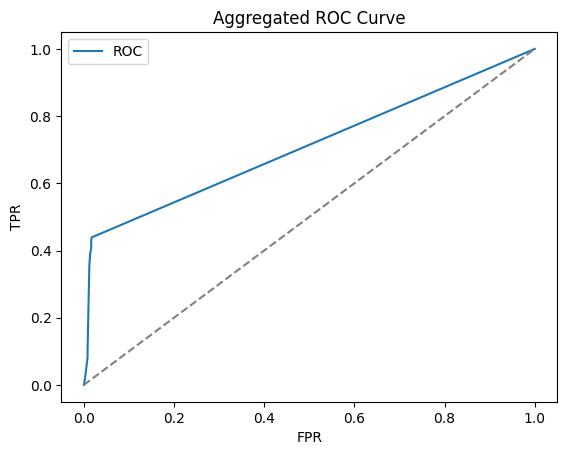

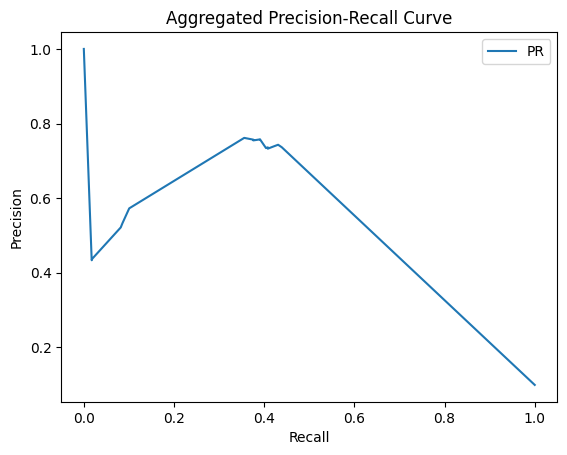

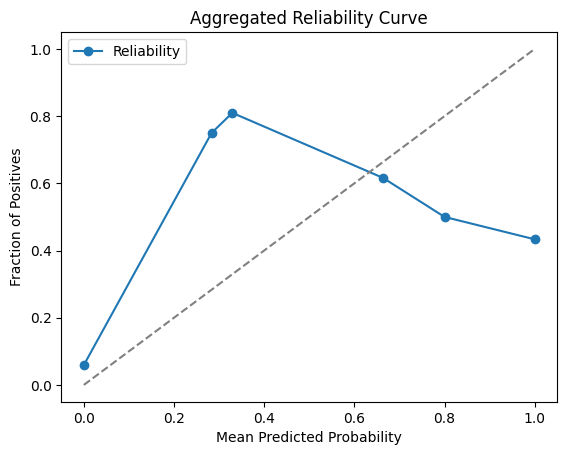

In [43]:
aggregate_and_plot_weighted(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    target=TARGETS[0],  # choose your target
    data=data  # your full 2023 DataFrame
)


Aggregating results from ..\skope_rules_weighted\rolling_random_search\rolling for target 'Price_negative_secondary'...
Found 45 folds.
    fold  precision    recall        f1       auc       mcc  weighted_mcc
0      1   1.000000  1.000000  1.000000  1.000000  1.000000      1.000000
1      2   1.000000  0.750000  0.857143  0.875000  0.863397      0.700727
2      3   1.000000  0.378378  0.549020  0.689189  0.567334      0.332388
3      4   1.000000  0.583333  0.736842  0.791667  0.751809      0.538768
4      5   1.000000  0.800000  0.888889  0.900000  0.891696      0.749067
5      6   1.000000  0.285714  0.444444  0.642857  0.526411      0.328055
6      7   1.000000  0.416667  0.588235  0.708333  0.631485      0.411693
7      8   1.000000  0.714286  0.833333  0.857143  0.839953      0.661978
8      9   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
9     10   1.000000  0.562500  0.720000  0.781250  0.733305      0.513404
10    11   1.000000  0.900000  0.947368  0.950000 

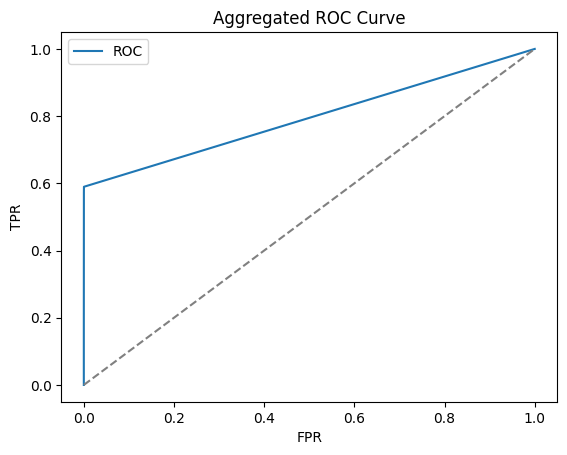

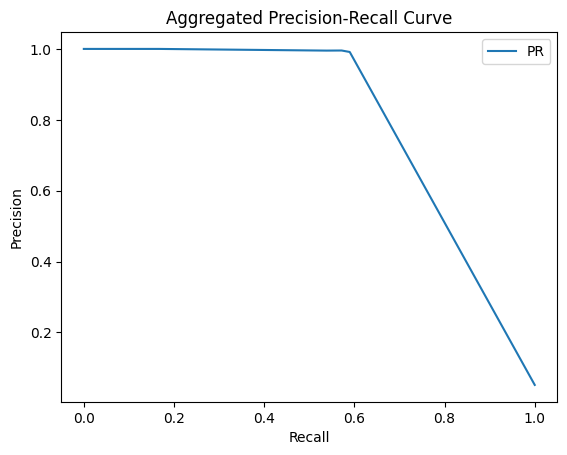

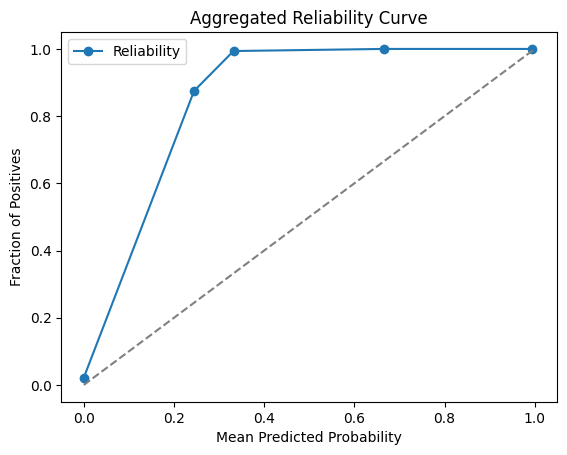

In [44]:
aggregate_and_plot_weighted(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    target=TARGETS[1],  # choose your target
    data=data  # your full 2023 DataFrame
)


Aggregating results from ..\skope_rules_weighted\rolling_random_search\rolling for target 'Price_positive_tertiary'...
Found 45 folds.
    fold  precision    recall        f1       auc       mcc  weighted_mcc
0      1   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
1      2   1.000000  0.500000  0.666667  0.750000  0.704987      0.495542
2      3   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
3      4   0.000000  0.000000  0.000000       NaN  0.000000      0.000000
4      5   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
5      6   1.000000  1.000000  1.000000  1.000000  1.000000      1.000000
6      7   1.000000  0.142857  0.250000  0.571429  0.371113      0.217575
7      8   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
8      9   1.000000  0.235294  0.380952  0.617647  0.465449      0.271899
9     10   1.000000  0.600000  0.750000  0.800000  0.764974      0.556600
10    11   0.000000  0.000000  0.000000       NaN  

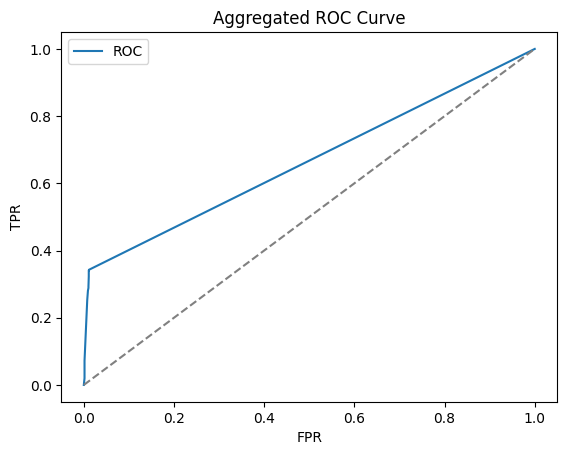

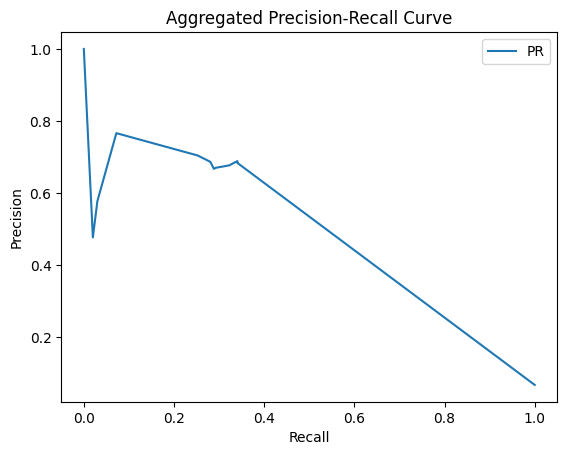

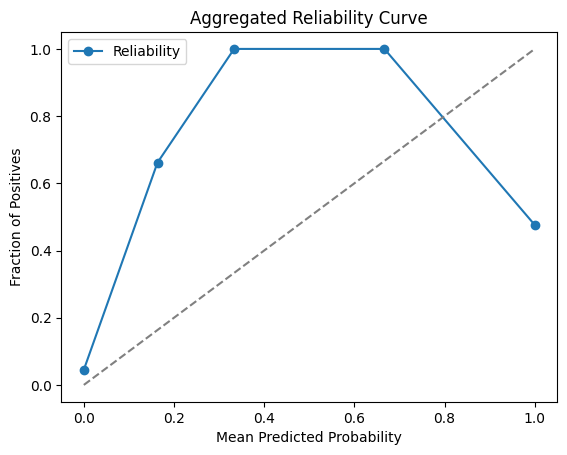

In [47]:
aggregate_and_plot_weighted(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    target=TARGETS[2],  # choose your target
    data=data  # your full 2023 DataFrame
)


Aggregating results from ..\skope_rules_weighted\rolling_random_search\rolling for target 'Price_negative_tertiary'...
Found 45 folds.
    fold  precision    recall        f1       auc       mcc  weighted_mcc
0      1   1.000000  0.400000  0.571429  0.700000  0.608276      0.382420
1      2   1.000000  0.687500  0.814815  0.843750  0.815846      0.620545
2      3   0.833333  0.416667  0.555556  0.705929  0.569345      0.326860
3      4   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
4      5   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
5      6   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
6      7   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
7      8   1.000000  0.333333  0.500000  0.666667  0.573883      0.371274
8      9   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
9     10   0.000000  0.000000  0.000000  0.500000  0.000000      0.000000
10    11   0.000000  0.000000  0.000000  0.500000  

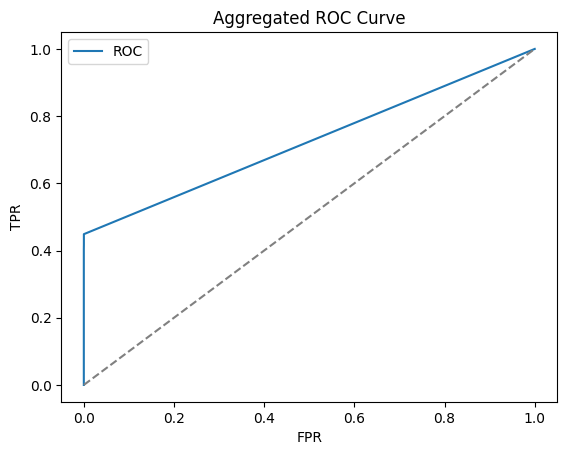

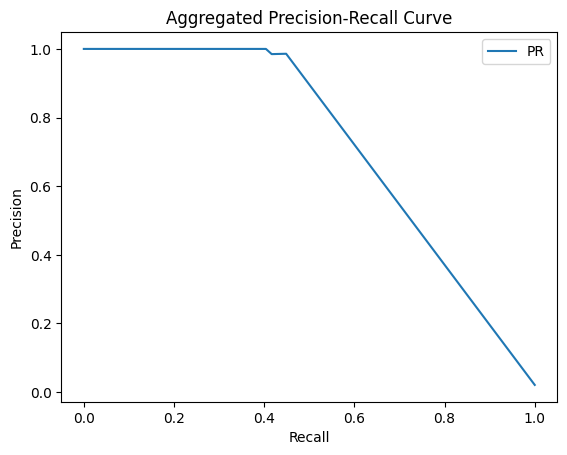

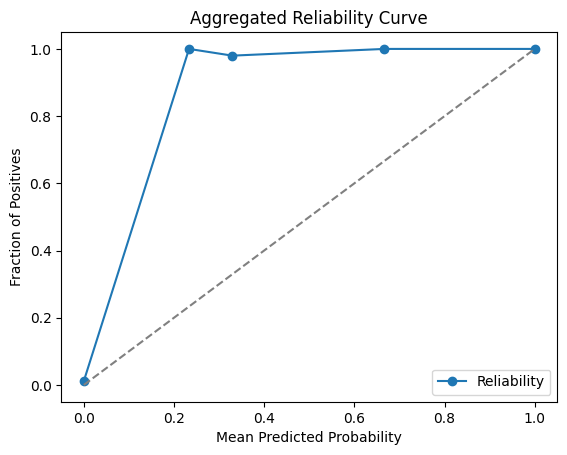

In [46]:
aggregate_and_plot_weighted(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    target=TARGETS[3],  # choose your target
    data=data  # your full 2023 DataFrame
)


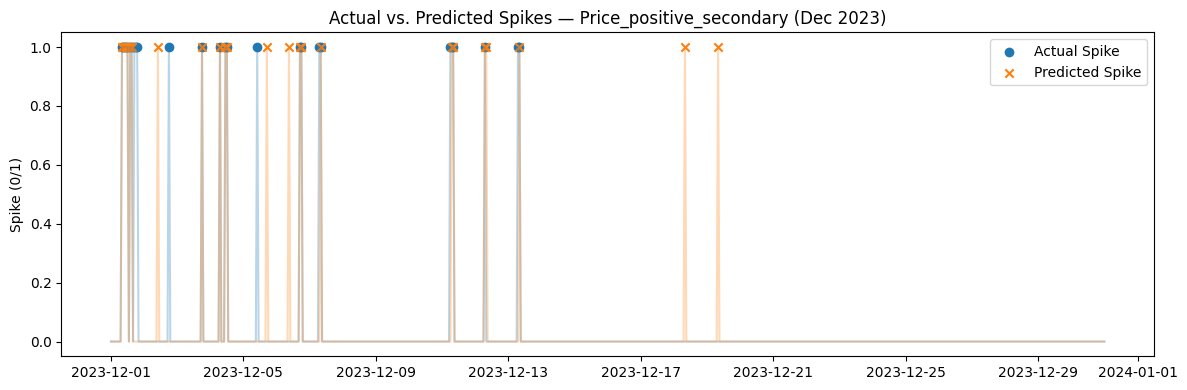

In [19]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Specify what to plot
TARGET        = "Price_positive_secondary"        # choose your target
MODEL_DIR     = Path("../skope_rules/static")    # base directory where models live
MODEL_PATH    = MODEL_DIR / TARGET / "model.pkl" # adjust if you used a different regime
MONTH_START   = "2023-12-01"
MONTH_END     = "2023-12-31"

# 2) Recompute features on your full data
#    (Assuming `data` is already your 2023 DataFrame with DateTimeIndex)
feat_defs = make_identity_feats(data, exclude=TARGETS)
X_all     = compute_features(data, feat_defs)

# 3) Slice out December 2023
dec_idx = pd.date_range(MONTH_START, MONTH_END, freq="H")
X_dec   = X_all.reindex(dec_idx).dropna()  # keeps only rows where all features exist

# 4) Recompute true labels for DEC based on your labeling method
y_all    = label_spikes(
    series=data[TARGET],
    train_window=(data.index[0], data.index[-1]),  # whole-year thresholds
    method=LABEL_METHOD,
    two_sided=TWO_SIDED,
    percentile_high=P_HI,
    percentile_low=P_LO,
    roll_window=ROLL_WINDOW,
    k=K_SIGMA
)
y_dec    = y_all.reindex(dec_idx).dropna()

# 5) Load your saved model
clf = joblib.load(MODEL_PATH)

# 6) Compute predictions
try:
    y_score = clf.decision_function(X_dec.values)
except AttributeError:
    y_score = clf.score_top_rules(X_dec.values).astype(float)
y_pred = (y_score >= 0.5).astype(int)

# 7) Build DataFrame for plotting
df = pd.DataFrame({
    "actual":      y_dec,
    "pred_binary": y_pred
}, index=y_dec.index)

# 8) Plot with 'o' for actual, 'x' for predicted
plt.figure(figsize=(12,4))
plt.plot(df.index, df["actual"],   color="C0", alpha=0.3)
plt.plot(df.index, df["pred_binary"], color="C1", alpha=0.3)
plt.scatter(df.index[df["actual"]==1],    df["actual"][df["actual"]==1],
            marker="o", color="C0", label="Actual Spike")
plt.scatter(df.index[df["pred_binary"]==1], df["pred_binary"][df["pred_binary"]==1],
            marker="x", color="C1", label="Predicted Spike")
plt.title(f"Actual vs. Predicted Spikes — {TARGET} (Dec 2023)")
plt.ylabel("Spike (0/1)")
plt.legend()
plt.tight_layout()
plt.show()


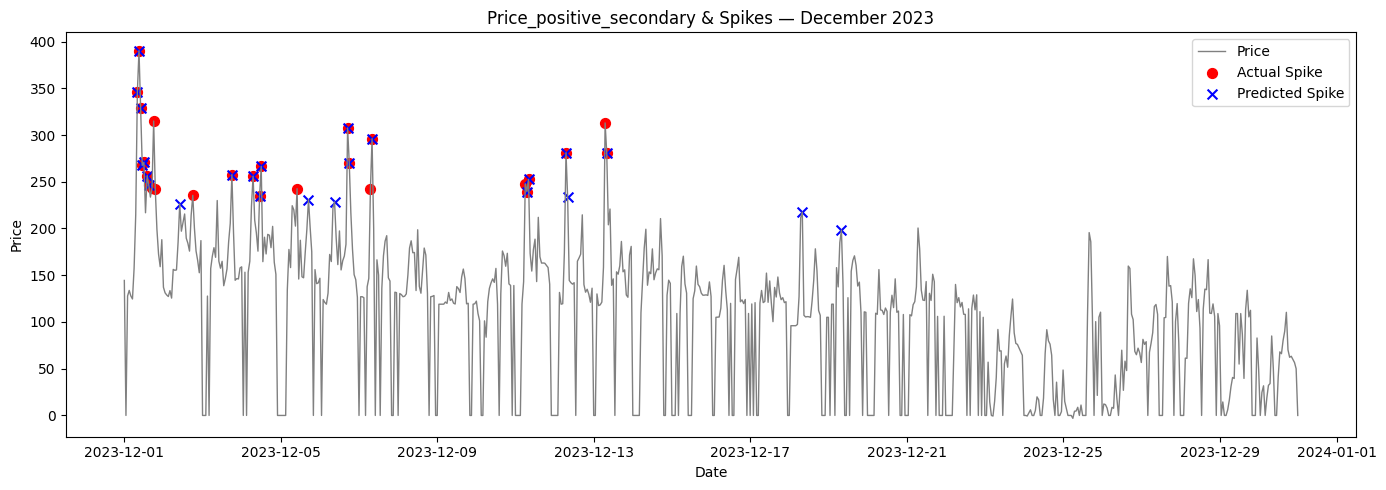

In [20]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

# ——— Parameters ———
TARGET       = "Price_positive_secondary"
MODEL_DIR    = Path("../skope_rules/static") / TARGET
MODEL_PATH   = MODEL_DIR / "model.pkl"
MONTH_START  = "2023-12-01"
MONTH_END    = "2023-12-31"

# ——— 1) Load and prepare data ———
# Assume `data` is your original hourly DataFrame covering all 2023
feat_defs = make_identity_feats(data, exclude=TARGETS)
X_all     = compute_features(data, feat_defs)

# Recompute labels for full year
y_all = label_spikes(
    series=data[TARGET],
    train_window=(data.index[0], data.index[-1]),
    method=LABEL_METHOD,
    two_sided=TWO_SIDED,
    percentile_high=P_HI,
    percentile_low=P_LO,
    roll_window=ROLL_WINDOW,
    k=K_SIGMA
)

# Slice December
dec_idx = pd.date_range(MONTH_START, MONTH_END, freq="H")
price_dec = data[TARGET].reindex(dec_idx).dropna()
X_dec     = X_all.reindex(dec_idx).dropna()
y_dec     = y_all.reindex(dec_idx).dropna()

# ——— 2) Load model & get predictions ———
clf = joblib.load(MODEL_PATH)
try:
    y_score = clf.decision_function(X_dec.values)
except AttributeError:
    y_score = clf.score_top_rules(X_dec.values).astype(float)
y_pred = (y_score >= 0.5).astype(int)

# ——— 3) Build DataFrame ———
df = pd.DataFrame({
    "price":      price_dec,
    "actual":     y_dec,
    "predicted":  y_pred
}, index=price_dec.index)

# ——— 4) Plot price series + spike markers ———
plt.figure(figsize=(14,5))

# Plot the price line
plt.plot(df.index, df["price"], color="gray", linewidth=1, label="Price")

# Overlay actual spike markers
plt.scatter(
    df.index[df["actual"]==1], 
    df["price"][df["actual"]==1],
    marker="o", color="red", s=50, label="Actual Spike"
)

# Overlay predicted spike markers
plt.scatter(
    df.index[df["predicted"]==1], 
    df["price"][df["predicted"]==1],
    marker="x", color="blue", s=50, label="Predicted Spike"
)

plt.title(f"{TARGET} & Spikes — December 2023")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
import json, numpy as np, pandas as pd, joblib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve


def aggregate_and_plot(base_dir: Path, target: str, data: pd.DataFrame):
    # 1) Locate and sort folds numerically
    fold_dirs = list(base_dir.glob("fold_*"))
    fold_dirs = sorted(fold_dirs, key=lambda p: int(p.name.split("_")[1]))

    y_true_all, y_score_all, metrics_list = [], [], []
    for fold in fold_dirs:
        tgt_dir = fold / target
        mfile   = tgt_dir / "metrics.json"
        if not mfile.exists():
            continue

        info = json.loads(mfile.read_text())
        # extract numeric fold index
        fold_idx = int(fold.name.split("_")[1])
        # build row, including mcc explicitly
        row = {
            "fold": fold_idx,
            "precision": info["metrics"].get("precision", np.nan),
            "recall":    info["metrics"].get("recall",    np.nan),
            "f1":        info["metrics"].get("f1",        np.nan),
            "auc":       info["metrics"].get("auc",       np.nan),
            "mcc":       info["metrics"].get("mcc",       np.nan)
        }
        metrics_list.append(row)

        # reconstruct test slice
        s0, s1 = info.get("test_window", (None, None))
        if s0 is None or s1 is None:
            continue
        raw       = data.loc[s0:s1]
        feat_defs = make_identity_feats(raw, exclude=TARGETS)
        X_test    = compute_features(raw, feat_defs)
        y_all     = label_spikes(
            raw[target],
            train_window=(data.index[0], data.index[-1]),
            method=LABEL_METHOD,
            two_sided=TWO_SIDED,
            percentile_high=P_HI,
            percentile_low=P_LO,
            roll_window=ROLL_WINDOW,
            k=K_SIGMA
        )
        idx   = X_test.index.intersection(y_all.dropna().index)
        X_te  = X_test.loc[idx].dropna()
        y_te  = y_all.loc[X_te.index]

        # load model & score
        model = joblib.load(tgt_dir / "model.pkl")
        try:
            y_score = model.decision_function(X_te.values)
        except AttributeError:
            y_score = model.score_top_rules(X_te.values).astype(float)

        y_true_all.append(y_te.reset_index(drop=True))
        y_score_all.append(y_score)

    if not metrics_list:
        raise RuntimeError(f"No folds found under {base_dir}. Aborting.")

    # 2) Build and print sorted metrics table
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.sort_values("fold").reset_index(drop=True)
    print(metrics_df)

    # 3) Concatenate for curves
    y_true  = pd.concat(y_true_all, ignore_index=True)
    y_score = np.concatenate(y_score_all)

    # 4) Plot aggregated ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("Aggregated ROC Curve")
    plt.legend()
    plt.show()

    # 5) Plot aggregated Precision-Recall
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    plt.figure()
    plt.plot(rec, prec, label="PR")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Aggregated Precision-Recall Curve")
    plt.legend()
    plt.show()

    # 6) Plot aggregated Reliability curve
    y_prob = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label="Reliability")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Aggregated Reliability Curve")
    plt.legend()
    plt.show()

    fold  precision    recall        f1       auc       mcc
0      1   0.000000  0.000000  0.000000  0.500000  0.000000
1      2   1.000000  0.600000  0.750000  0.800000  0.769888
2      3   1.000000  1.000000  1.000000  1.000000  1.000000
3      4   1.000000  0.375000  0.545455  0.687500  0.603023
4      5   1.000000  1.000000  1.000000  1.000000  1.000000
5      6   1.000000  0.333333  0.500000  0.666667  0.573883
6      7   1.000000  0.466667  0.636364  0.733333  0.665942
7      8   1.000000  0.428571  0.600000  0.714286  0.646670
8      9   1.000000  0.700000  0.823529  0.850000  0.820200
9     10   1.000000  0.555556  0.714286  0.777778  0.736154
10    11   1.000000  1.000000  1.000000  1.000000  1.000000
11    12   1.000000  0.500000  0.666667  0.750000  0.700649
12    13   1.000000  0.176471  0.300000  0.588235  0.401867
13    14   1.000000  0.500000  0.666667  0.750000  0.704987
14    15   0.000000  0.000000  0.000000       NaN  0.000000
15    16   0.000000  0.000000  0.000000 

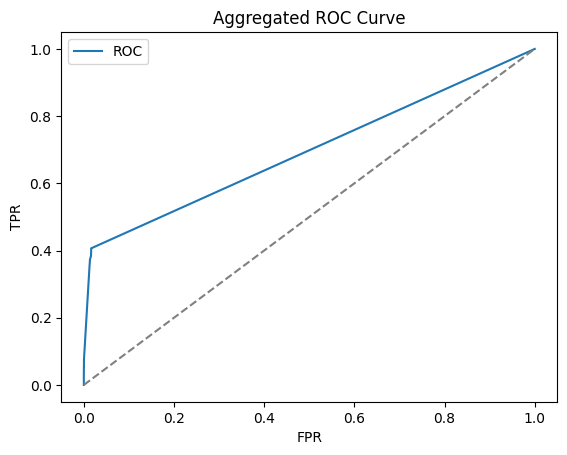

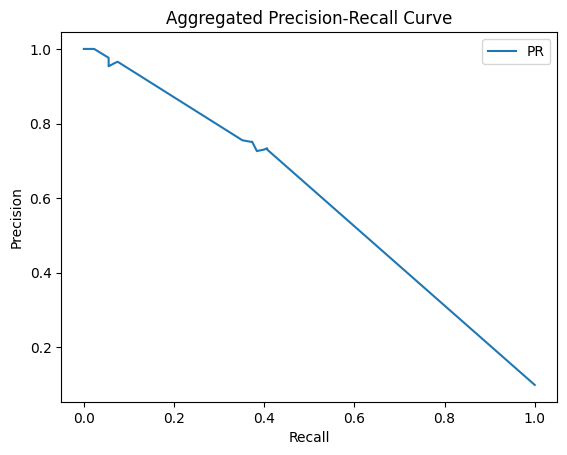

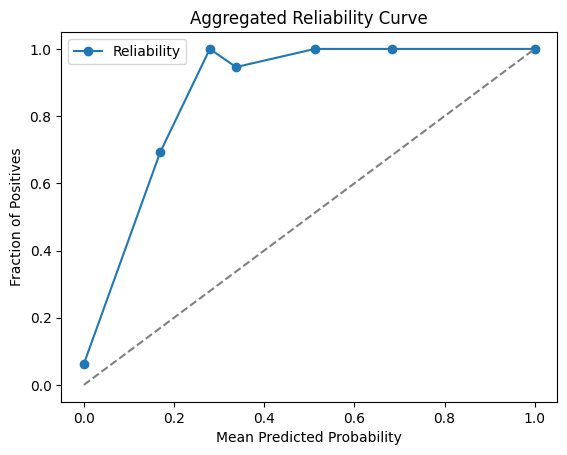

In [23]:
aggregate_and_plot(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    target=TARGETS[0],  # choose your target
    data=data  # your full 2023 DataFrame
)


    fold  precision    recall        f1       auc       mcc
0      1   1.000000  1.000000  1.000000  1.000000  1.000000
1      2   1.000000  0.750000  0.857143  0.875000  0.863397
2      3   1.000000  0.378378  0.549020  0.689189  0.567334
3      4   1.000000  0.583333  0.736842  0.791667  0.751809
4      5   1.000000  0.800000  0.888889  0.900000  0.891696
5      6   1.000000  0.142857  0.250000  0.571429  0.371113
6      7   1.000000  0.416667  0.588235  0.708333  0.631485
7      8   1.000000  0.714286  0.833333  0.857143  0.839953
8      9   0.000000  0.000000  0.000000  0.500000  0.000000
9     10   1.000000  0.375000  0.545455  0.687500  0.593171
10    11   1.000000  0.700000  0.823529  0.850000  0.828828
11    12   0.933333  1.000000  0.965517  0.996985  0.962950
12    13   1.000000  0.333333  0.500000  0.666667  0.559360
13    14   1.000000  0.222222  0.363636  0.611111  0.450835
14    15   1.000000  0.083333  0.153846  0.541667  0.279006
15    16   1.000000  0.500000  0.666667 

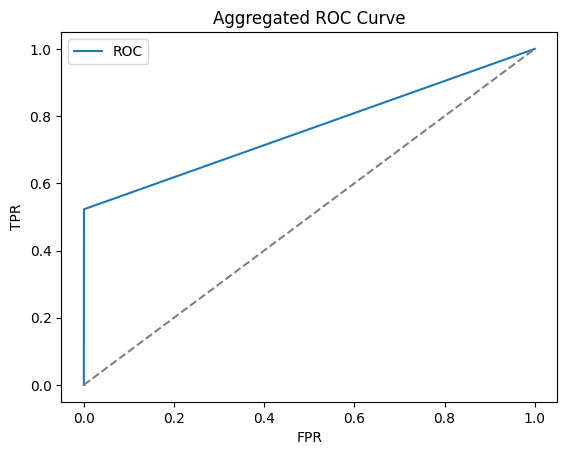

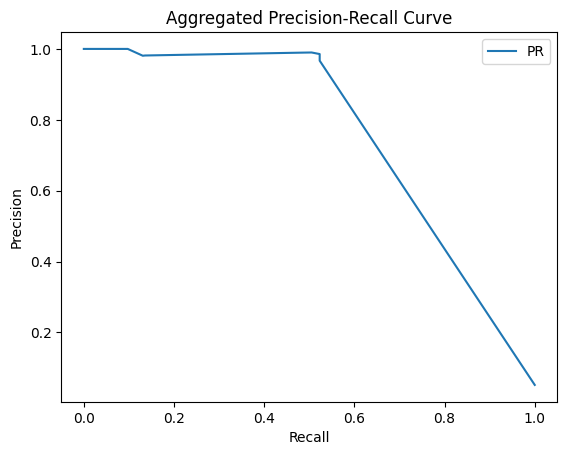

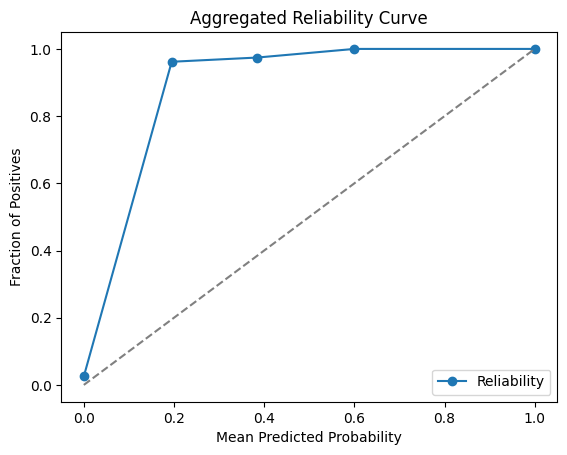

In [24]:
aggregate_and_plot(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    target=TARGETS[1],  # choose your target
    data=data  # your full 2023 DataFrame
)

    fold  precision    recall        f1       auc       mcc
0      1   0.000000  0.000000  0.000000  0.500000  0.000000
1      2   1.000000  0.500000  0.666667  0.750000  0.704987
2      3   0.000000  0.000000  0.000000  0.500000  0.000000
3      4   0.000000  0.000000  0.000000       NaN  0.000000
4      5   0.000000  0.000000  0.000000  0.500000  0.000000
5      6   1.000000  1.000000  1.000000  1.000000  1.000000
6      7   1.000000  0.142857  0.250000  0.571429  0.371113
7      8   0.000000  0.000000  0.000000  0.500000  0.000000
8      9   1.000000  0.235294  0.380952  0.617647  0.465449
9     10   1.000000  0.400000  0.571429  0.700000  0.620778
10    11   0.000000  0.000000  0.000000       NaN  0.000000
11    12   0.000000  0.000000  0.000000  0.500000  0.000000
12    13   0.000000  0.000000  0.000000  0.500000  0.000000
13    14   0.000000  0.000000  0.000000  0.500000  0.000000
14    15   0.000000  0.000000  0.000000  0.500000  0.000000
15    16   0.000000  0.000000  0.000000 

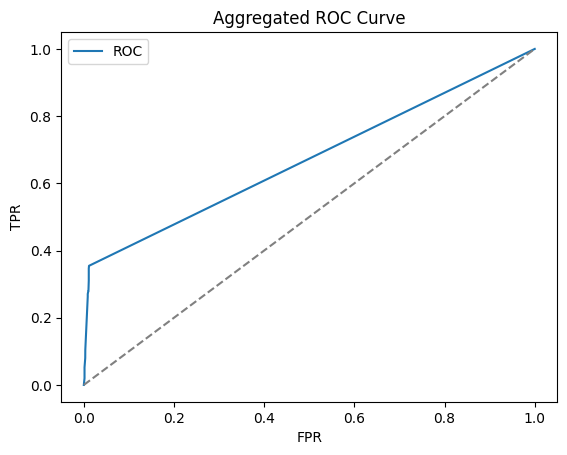

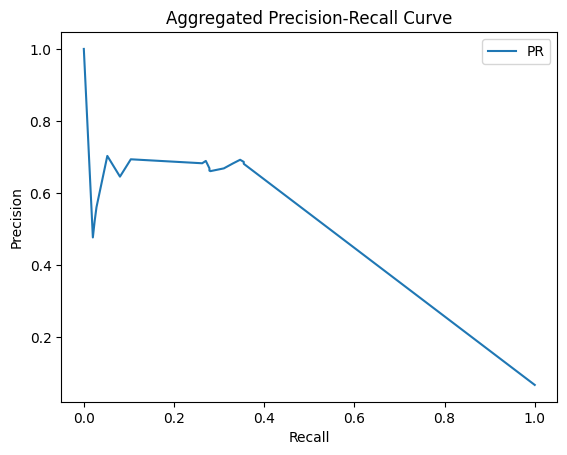

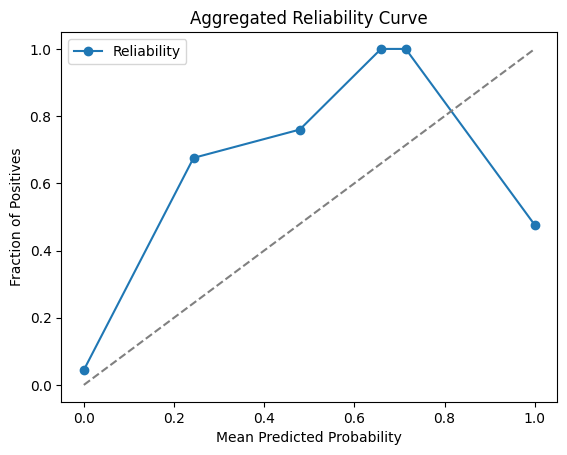

In [25]:
aggregate_and_plot(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    target=TARGETS[2],  # choose your target
    data=data  # your full 2023 DataFrame
)

    fold  precision    recall        f1       auc       mcc
0      1        1.0  0.250000  0.400000  0.625000  0.476439
1      2        1.0  0.562500  0.720000  0.781250  0.733305
2      3        1.0  0.416667  0.588235  0.708333  0.631485
3      4        0.0  0.000000  0.000000  0.500000  0.000000
4      5        0.0  0.000000  0.000000  0.500000  0.000000
5      6        0.0  0.000000  0.000000  0.500000  0.000000
6      7        0.0  0.000000  0.000000  0.500000  0.000000
7      8        1.0  0.333333  0.500000  0.666667  0.573883
8      9        0.0  0.000000  0.000000  0.500000  0.000000
9     10        0.0  0.000000  0.000000  0.500000  0.000000
10    11        0.0  0.000000  0.000000  0.500000  0.000000
11    12        0.0  0.000000  0.000000       NaN  0.000000
12    13        0.0  0.000000  0.000000       NaN  0.000000
13    14        1.0  0.666667  0.800000  0.833333  0.811503
14    15        1.0  0.500000  0.666667  0.750000  0.698430
15    16        0.0  0.000000  0.000000 

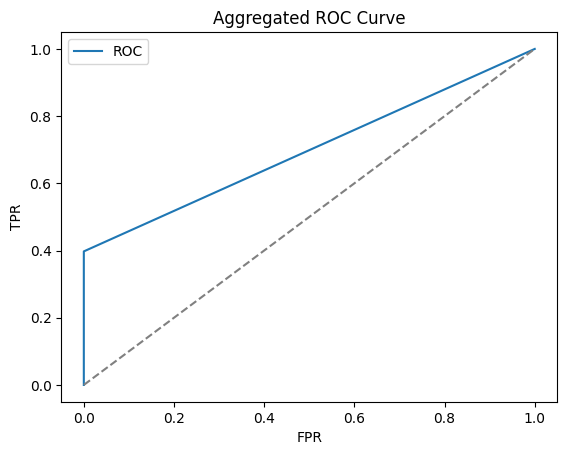

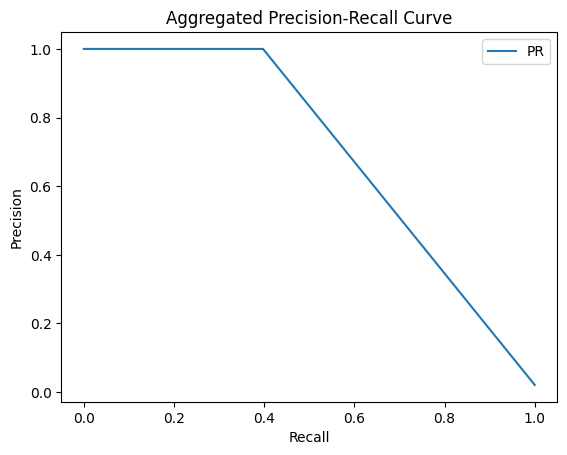

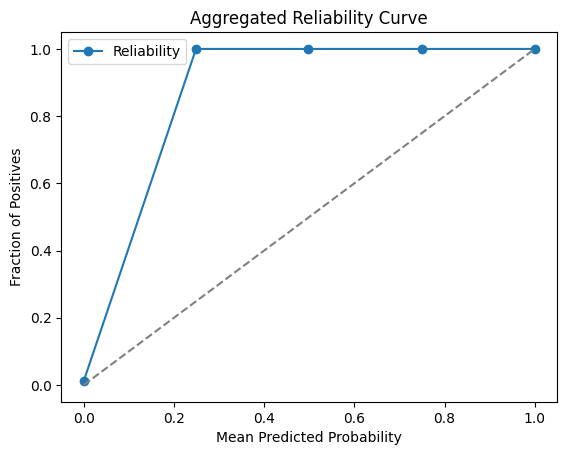

In [26]:
aggregate_and_plot(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    target=TARGETS[3],  # choose your target
    data=data  # your full 2023 DataFrame
)

In [15]:
import json
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import shap

def aggregate_feature_importance(
    base_dir: Path,
    target: str,
    data: pd.DataFrame,
    top_n: int = 20,
    fold_to_plot: int = None
):
    """
    For each fold_* under base_dir/target:
      - Reconstruct X_test as in aggregate_and_plot
      - Load the trained SkopeRules model
      - Compute SHAP values via KernelExplainer
    Then:
      - Concatenate all SHAP values & feature names
      - Plot a SHAP beeswarm (summary) plot
      - Plot a bar chart of top_n features by mean(|SHAP|)
      - Plot a SHAP violin plot for top_n features

    Parameters
    ----------
    base_dir : Path
        Root directory containing fold_* subfolders.
    target : str
        Name of the service target (subfolder under each fold).
    data : pd.DataFrame
        Full time-indexed DataFrame to reconstruct test windows.
    top_n : int
        Number of top features to display.
    fold_to_plot : int, optional
        If provided, overlay the SHAP beeswarm for this fold in a separate figure.
    """
    # find and sort folds
    fold_dirs = sorted(base_dir.glob("fold_*"),
                       key=lambda p: int(p.name.split("_")[1]))
    all_shap_vals = []
    feature_names = None

    # Optionally store per-fold shap for overlay
    shap_for_fold = {}

    for fold in fold_dirs:
        fold_idx = int(fold.name.split("_")[1])
        tgt_dir  = fold / target
        mfile    = tgt_dir / "metrics.json"
        if not mfile.exists():
            continue

        info = json.loads(mfile.read_text())
        # reconstruct test slice
        tw = info.get("test_window", None)
        if tw is None:
            continue
        s0, s1 = tw
        raw = data.loc[s0:s1]

        # build features & labels
        feat_defs = make_identity_feats(raw, exclude=TARGETS)
        X_test    = compute_features(raw, feat_defs)
        y_all     = label_spikes(
            raw[target],
            train_window=(data.index[0], data.index[-1]),
            method=LABEL_METHOD,
            two_sided=TWO_SIDED,
            percentile_high=P_HI,
            percentile_low=P_LO,
            roll_window=ROLL_WINDOW,
            k=K_SIGMA
        )
        idx   = X_test.index.intersection(y_all.dropna().index)
        X_te  = X_test.loc[idx].dropna()
        y_te  = y_all.loc[X_te.index]

        # load model
        model = joblib.load(tgt_dir / "model.pkl")

        # on-demand: define a prediction function for KernelExplainer
        def model_pred(X):
            # ensures 2d numpy array
            return model.decision_function(X).ravel()

        # pick a small background sample for KernelExplainer
        bg = shap.sample(X_te, nsamples=100, random_state=42)
        explainer = shap.KernelExplainer(model_pred, bg.values)

        # compute SHAP values on test set (may be slow)
        shap_vals = explainer.shap_values(X_te.values, nsamples=100)

        # record feature names once
        if feature_names is None:
            feature_names = X_te.columns.tolist()

        # store
        all_shap_vals.append(pd.DataFrame(shap_vals,
                                          columns=feature_names))
        if fold_to_plot is not None and fold_idx == fold_to_plot:
            shap_for_fold[fold_idx] = shap_vals

    if not all_shap_vals:
        raise RuntimeError(f"No valid folds found under {base_dir}")

    # concatenate SHAP across folds
    shap_df = pd.concat(all_shap_vals, ignore_index=True)

    # 1) Beeswarm (summary) plot for all folds
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_df.values, features=shap_df,
                      feature_names=feature_names, plot_type="dot",
                      show=False)
    plt.title(f"SHAP Beeswarm (All folds) — Top {top_n}")
    plt.tight_layout()
    plt.show()

    # 2) Bar chart of mean(|SHAP|)
    mean_abs_shap = np.abs(shap_df).mean().sort_values(ascending=False)
    top_features = mean_abs_shap.iloc[:top_n]

    plt.figure(figsize=(8, 6))
    top_features.plot.barh()
    plt.gca().invert_yaxis()
    plt.xlabel("Mean |SHAP value|")
    plt.title(f"Top {top_n} Features by Mean |SHAP| (Aggregated)")
    plt.tight_layout()
    plt.show()

    # 3) Violin plot of SHAP distributions for top features
    shap.summary_plot(shap_df[top_features.index].values,
                      features=shap_df[top_features.index],
                      feature_names=top_features.index.tolist(),
                      plot_type="violin", show=False)
    plt.title(f"SHAP Violin Plot — Top {top_n} Features")
    plt.tight_layout()
    plt.show()

    # 4) If requested, plot the beeswarm for a single fold
    if fold_to_plot in shap_for_fold:
        sv = shap_for_fold[fold_to_plot]
        plt.figure(figsize=(10, 6))
        shap.summary_plot(sv, features=X_te, feature_names=feature_names,
                          plot_type="dot", show=False)
        plt.title(f"SHAP Beeswarm — fold_{fold_to_plot}")
        plt.tight_layout()
        plt.show()


100%|██████████| 167/167 [00:20<00:00,  8.33it/s]


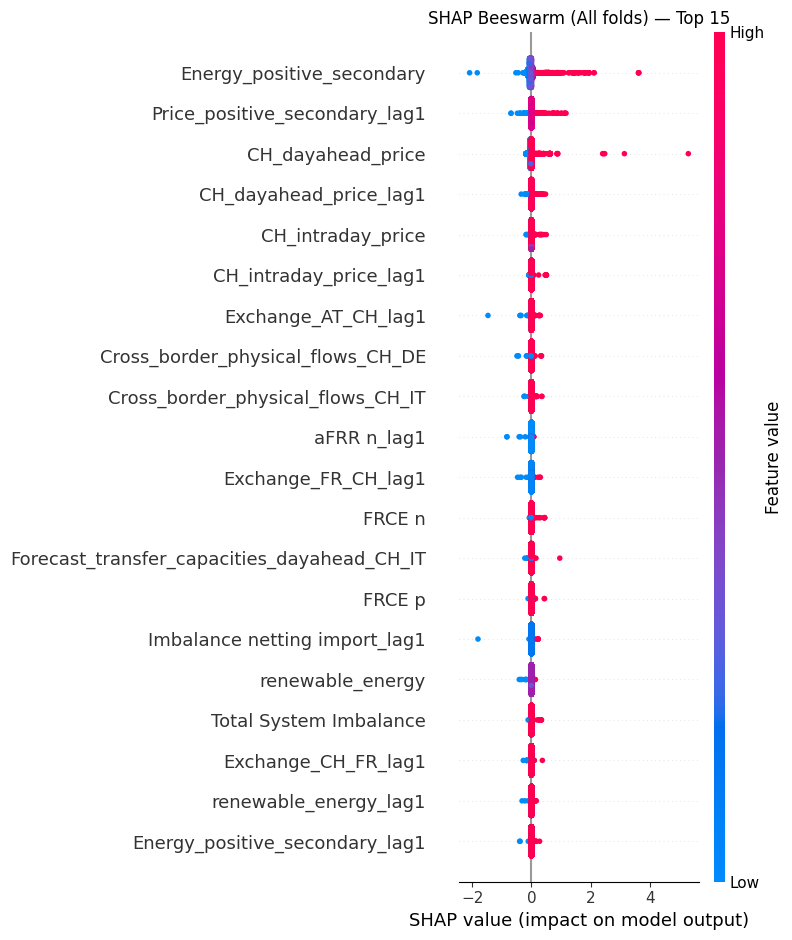

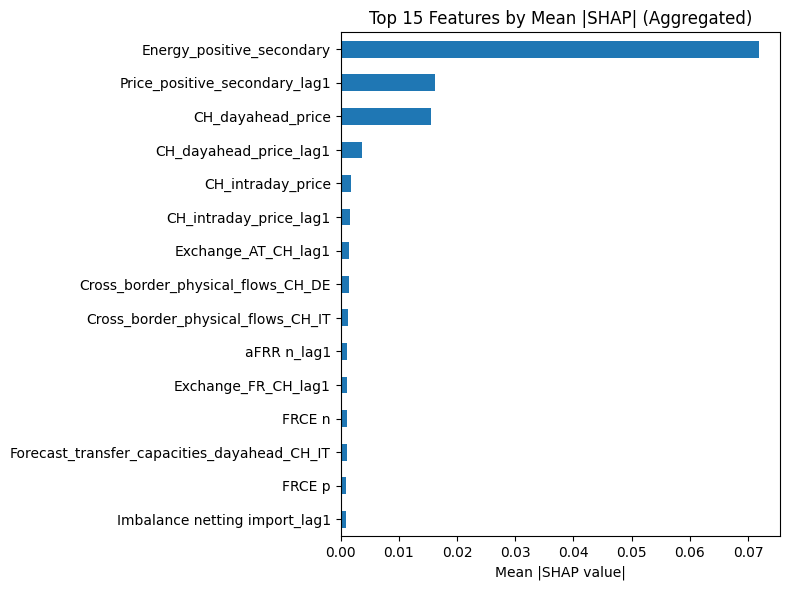

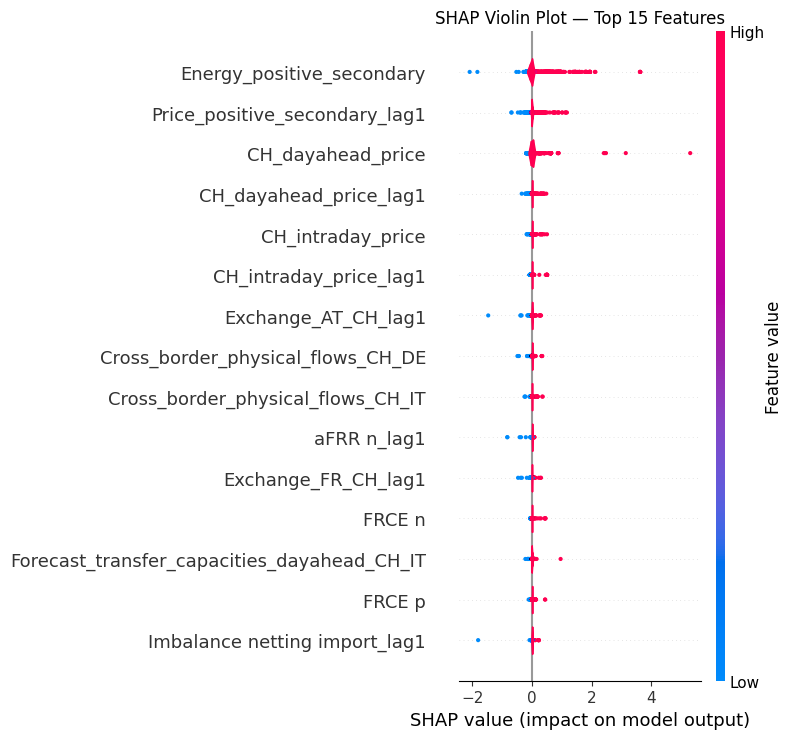

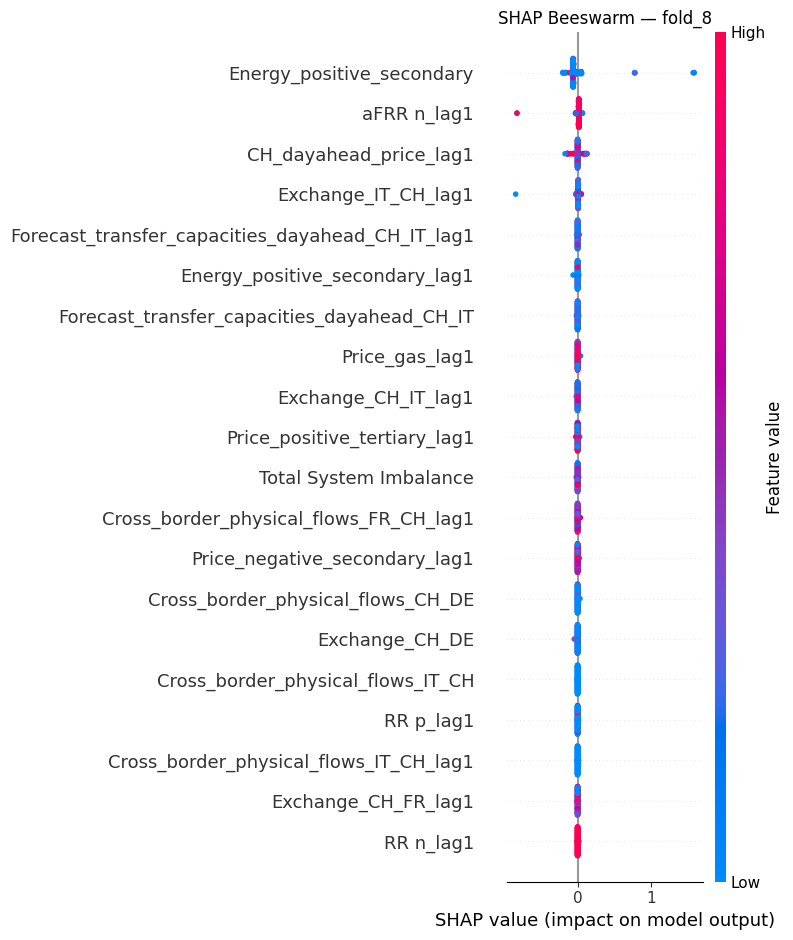

In [16]:
aggregate_feature_importance(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    target=TARGETS[0],  # choose your target
    data=data,
    top_n=15,
    fold_to_plot=8
)

In [28]:
import json
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve

def save_plots_per_fold(
    base_dir: Path,
    target: str,
    data: pd.DataFrame,
    n_bins: int = 10,
    score_threshold: float = 0.5
) -> None:
    """
    For each fold in base_dir, reconstruct test data and model scores,
    then generate and save diagnostic plots (ROC, PR, Reliability)
    and a price series plot with actual vs. predicted spikes markers
    into the corresponding fold/target subdirectory.

    The price series plot overlays the actual price values over the test window,
    marking actual spike events with red 'o' and predicted spike events with blue 'x'.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    target : str
        Name of the target column/subfolder (e.g., "Price_positive_secondary").
    data : pd.DataFrame
        Full time-indexed DataFrame including the target price series.
    n_bins : int
        Number of bins for the calibration curve.
    score_threshold : float
        Threshold on normalized score to classify predicted spikes.
    """
    # Locate and sort fold directories numerically
    fold_dirs = sorted(
        base_dir.glob("fold_*"),
        key=lambda p: int(p.name.split('_')[1])
    )

    for fold in fold_dirs:
        fold_idx = fold.name
        tgt_dir = fold / target
        mfile = tgt_dir / "metrics.json"
        model_file = tgt_dir / "model.pkl"

        # Skip if required files are missing
        if not mfile.exists() or not model_file.exists():
            continue

        # Load metrics to get test window
        info = json.loads(mfile.read_text())
        tw = info.get("test_window", None)
        if not tw:
            continue
        s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])

        # Reconstruct test slice of raw price series
        raw = data.loc[s0:s1]
        price_series = raw[target]

        # Feature and label reconstruction
        feat_defs = make_identity_feats(raw, exclude=TARGETS)
        X_test = compute_features(raw, feat_defs)
        y_all = label_spikes(
            raw[target],
            train_window=(data.index[0], data.index[-1]),
            method=LABEL_METHOD,
            two_sided=TWO_SIDED,
            percentile_high=P_HI,
            percentile_low=P_LO,
            roll_window=ROLL_WINDOW,
            k=K_SIGMA
        )
        # Align indices and drop any NaNs before scoring
        common_idx = X_test.index.intersection(y_all.dropna().index)
        X_te = X_test.loc[common_idx].dropna()
        y_te = y_all.loc[X_te.index]

        # Load model
        model = joblib.load(model_file)

        # Compute model score, handling possible missing decision_function
        try:
            y_score = model.decision_function(X_te.values)
        except AttributeError:
            y_score = model.score_top_rules(X_te.values).astype(float)

        # Normalize scores to [0,1] for plotting
        y_prob = y_score.copy()
        if np.nanmin(y_prob) < 0 or np.nanmax(y_prob) > 1:
            y_prob = (y_prob - np.nanmin(y_prob)) / (np.nanmax(y_prob) - np.nanmin(y_prob))

        # Derive binary predictions
        y_pred = (y_prob >= score_threshold).astype(int)

        # Create full-window actual and predicted series
        actual_series = pd.Series(0, index=price_series.index)
        actual_series.loc[y_te.index[y_te == 1]] = 1
        predicted_series = pd.Series(0, index=price_series.index)
        predicted_series.loc[y_te.index[y_pred == 1]] = 1

        # Ensure output directory exists
        tgt_dir.mkdir(parents=True, exist_ok=True)

        # 1) ROC Curve
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1], [0,1], "--", color="grey")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_roc_curve.png")
        plt.close()

        # 2) Precision-Recall Curve
        prec, rec, _ = precision_recall_curve(y_te, y_score)
        plt.figure()
        plt.plot(rec, prec, label="PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_pr_curve.png")
        plt.close()

        # 3) Reliability Curve
        prob_true, prob_pred = calibration_curve(y_te, y_prob, n_bins=n_bins)
        plt.figure()
        plt.plot(prob_pred, prob_true, marker="o", label="Reliability")
        plt.plot([0,1], [0,1], "--", color="grey", label="Ideal")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Reliability Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_reliability_curve.png")
        plt.close()

        # 4) Price series with actual vs predicted spikes
        plt.figure(figsize=(14,5))
        plt.plot(price_series.index, price_series.values,
                 color="gray", linewidth=1, label="Price")
        # Mark actual spikes with 'o'
        plt.scatter(
            actual_series[actual_series==1].index,
            price_series.loc[actual_series==1],
            marker="o", color="red", s=50, label="Actual Spike"
        )
        # Mark predicted spikes with 'x'
        plt.scatter(
            predicted_series[predicted_series==1].index,
            price_series.loc[predicted_series==1],
            marker="x", color="blue", s=50, label="Predicted Spike"
        )
        plt.title(f"Price & Spikes — {fold_idx}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(tgt_dir / f"{fold_idx}_price_spikes.png")
        plt.close()


In [32]:
save_plots_per_fold(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    target=TARGETS[3],  # choose your target
    data=data,           # your full 2023 DataFrame
    n_bins=10            # number of bins for reliability curve
)

In [50]:
import json
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve
import shap
from typing import List


def save_plots_per_fold(
    base_dir: Path,
    target: str,
    data: pd.DataFrame,
    n_bins: int = 10,
    score_threshold: float = 0.5
) -> None:
    """
    For each fold in base_dir, reconstruct test data and model scores,
    then generate and save diagnostic plots (ROC, PR, Reliability)
    and a price series plot with actual vs. predicted spikes markers
    into the corresponding fold/target subdirectory.

    The price series plot overlays the actual price values over the test window,
    marking actual spike events with red 'o' and predicted spike events with blue 'x'.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    target : str
        Name of the target column/subfolder (e.g., "Price_positive_secondary").
    data : pd.DataFrame
        Full time-indexed DataFrame including the target price series.
    n_bins : int
        Number of bins for the calibration curve.
    score_threshold : float
        Threshold on normalized score to classify predicted spikes.
    """
    # Locate and sort fold directories numerically
    fold_dirs = sorted(
        base_dir.glob("fold_*"),
        key=lambda p: int(p.name.split('_')[1])
    )

    for fold in fold_dirs:
        fold_idx = fold.name
        tgt_dir = fold / target
        mfile = tgt_dir / "metrics.json"
        model_file = tgt_dir / "model.pkl"

        # Skip if required files are missing
        if not mfile.exists() or not model_file.exists():
            continue

        # Load metrics to get test window
        info = json.loads(mfile.read_text())
        tw = info.get("test_window", None)
        if not tw:
            continue
        s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])

        # Reconstruct test slice of raw price series
        raw = data.loc[s0:s1]
        price_series = raw[target]

        # Feature and label reconstruction
        feat_defs = make_identity_feats(raw, exclude=TARGETS)
        X_test = compute_features(raw, feat_defs)
        y_all = label_spikes(
            raw[target],
            train_window=(data.index[0], data.index[-1]),
            method=LABEL_METHOD,
            two_sided=TWO_SIDED,
            percentile_high=P_HI,
            percentile_low=P_LO,
            roll_window=ROLL_WINDOW,
            k=K_SIGMA
        )
        common_idx = X_test.index.intersection(y_all.dropna().index)
        X_te = X_test.loc[common_idx].dropna()
        y_te = y_all.loc[X_te.index]

        # Load model
        model = joblib.load(model_file)
        try:
            y_score = model.decision_function(X_te.values)
        except AttributeError:
            y_score = model.score_top_rules(X_te.values).astype(float)

        # Normalize scores
        y_prob = y_score.copy()
        if np.nanmin(y_prob) < 0 or np.nanmax(y_prob) > 1:
            y_prob = (y_prob - np.nanmin(y_prob)) / (np.nanmax(y_prob) - np.nanmin(y_prob))

        # Binary predictions
        y_pred = (y_prob >= score_threshold).astype(int)

        # Prepare marker series
        actual_series = pd.Series(0, index=price_series.index)
        actual_series.loc[y_te.index[y_te == 1]] = 1
        predicted_series = pd.Series(0, index=price_series.index)
        predicted_series.loc[y_te.index[y_pred == 1]] = 1

        # Ensure output directory exists
        tgt_dir.mkdir(parents=True, exist_ok=True)

        # 1) ROC Curve
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1],[0,1],"--",color="grey")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_roc_curve.png")
        plt.close()

        # 2) Precision-Recall
        prec, rec, _ = precision_recall_curve(y_te, y_score)
        plt.figure()
        plt.plot(rec, prec, label="PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_pr_curve.png")
        plt.close()

        # 3) Calibration
        prob_true, prob_pred = calibration_curve(y_te, y_prob, n_bins=n_bins)
        plt.figure()
        plt.plot(prob_pred, prob_true,marker="o",label="Reliability")
        plt.plot([0,1],[0,1],"--",color="grey",label="Ideal")
        plt.xlabel("Mean Pred Prob")
        plt.ylabel("Frac Pos")
        plt.title(f"Calibration — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_calibration.png")
        plt.close()

        # 4) Price & spikes
        plt.figure(figsize=(14,5))
        plt.plot(price_series.index,price_series.values,color="gray",linewidth=1,label="Price")
        plt.scatter(actual_series[actual_series==1].index,price_series.loc[actual_series==1],marker="o",color="red",s=50,label="Actual")
        plt.scatter(predicted_series[predicted_series==1].index,price_series.loc[predicted_series==1],marker="x",color="blue",s=50,label="Predicted")
        plt.title(f"Price & Spikes — {fold_idx}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(tgt_dir / f"{fold_idx}_price_spikes.png")
        plt.close()


def save_shap_plots_for_targets(
    base_dir: Path,
    targets: List[str],
    data: pd.DataFrame,
    background_samples: int = 100
) -> None:
    """
    For each target in targets and each fold in base_dir, compute SHAP values
    on that fold's test data and save a summary beeswarm plot to the fold/target
    directory.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    targets : List[str]
        List of target column names / subfolders (e.g., 4 service names).
    data : pd.DataFrame
        Full time-indexed DataFrame used to reconstruct test windows.
    background_samples : int
        Number of background samples for KernelExplainer.
    """
    fold_dirs = sorted(
        base_dir.glob("fold_*"),
        key=lambda p: int(p.name.split('_')[1])
    )

    for target in targets:
        for fold in fold_dirs:
            fold_idx = fold.name
            tgt_dir = fold / target
            mfile = tgt_dir / "metrics.json"
            model_file = tgt_dir / "model.pkl"
            if not mfile.exists() or not model_file.exists():
                continue

            # Load test window
            info = json.loads(mfile.read_text())
            tw = info.get("test_window", None)
            if not tw:
                continue
            s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])
            raw = data.loc[s0:s1]

            # Reconstruct features and labels
            feat_defs = make_identity_feats(raw, exclude=TARGETS)
            X_test = compute_features(raw, feat_defs)
            y_all = label_spikes(
                raw[target],
                train_window=(data.index[0], data.index[-1]),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )
            idx = X_test.index.intersection(y_all.dropna().index)
            X_te = X_test.loc[idx].dropna()

            # Load model
            model = joblib.load(model_file)

            # Define prediction function
            def pred_fn(X):
                try:
                    return model.decision_function(X)
                except AttributeError:
                    return model.score_top_rules(X).astype(float)

            # Background for explainer
            bg = shap.sample(X_te, background_samples, random_state=42)
            explainer = shap.KernelExplainer(pred_fn, bg.values)
            shap_vals = explainer.shap_values(X_te.values, nsamples=background_samples)

            # Ensure target folder exists
            tgt_dir.mkdir(parents=True, exist_ok=True)

            # Save beeswarm summary plot
            plt.figure(figsize=(10,6))
            shap.summary_plot(shap_vals, features=X_te, feature_names=X_te.columns, show=False)
            plt.title(f"SHAP Beeswarm — {target} — {fold_idx}")
            plt.tight_layout()
            plt.savefig(tgt_dir / f"{fold_idx}_shap_beeswarm.png")
            plt.close()


In [48]:
def save_shap_plots_for_targets_w(
    base_dir: Path,
    targets: List[str],
    data: pd.DataFrame,
    background_samples: int = 100
) -> None:
    """
    For each target in targets and each fold in base_dir, compute SHAP values
    on that fold's test data and save a summary beeswarm plot to the fold/target
    directory.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    targets : List[str]
        List of target column names / subfolders (e.g., 4 service names).
    data : pd.DataFrame
        Full time-indexed DataFrame used to reconstruct test windows.
    background_samples : int
        Number of background samples for KernelExplainer.
    """
    fold_dirs = sorted(
        base_dir.glob("fold_*"),
        key=lambda p: int(p.name.split('_')[1])
    )

    for target in targets:
        target_w = target + "_weighted"
        for fold in fold_dirs:
            fold_idx = fold.name
            tgt_dir = fold / target_w
            mfile = tgt_dir / "metrics.json"
            model_file = tgt_dir / "model.pkl"
            if not mfile.exists() or not model_file.exists():
                continue

            # Load test window
            info = json.loads(mfile.read_text())
            tw = info.get("test_window", None)
            if not tw:
                continue
            s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])
            raw = data.loc[s0:s1]

            # Reconstruct features and labels
            feat_defs = make_identity_feats(raw, exclude=TARGETS)
            X_test = compute_features(raw, feat_defs)
            y_all = label_spikes(
                raw[target],
                train_window=(data.index[0], data.index[-1]),
                method=LABEL_METHOD,
                two_sided=TWO_SIDED,
                percentile_high=P_HI,
                percentile_low=P_LO,
                roll_window=ROLL_WINDOW,
                k=K_SIGMA
            )
            idx = X_test.index.intersection(y_all.dropna().index)
            X_te = X_test.loc[idx].dropna()

            # Load model
            model = joblib.load(model_file)

            # Define prediction function
            def pred_fn(X):
                try:
                    return model.decision_function(X)
                except AttributeError:
                    return model.score_top_rules(X).astype(float)

            # Background for explainer
            bg = shap.sample(X_te, background_samples, random_state=42)
            explainer = shap.KernelExplainer(pred_fn, bg.values)
            shap_vals = explainer.shap_values(X_te.values, nsamples=background_samples)

            # Ensure target folder exists
            tgt_dir.mkdir(parents=True, exist_ok=True)

            # Save beeswarm summary plot
            plt.figure(figsize=(10,6))
            shap.summary_plot(shap_vals, features=X_te, feature_names=X_te.columns, show=False)
            plt.title(f"SHAP Beeswarm — {target} — {fold_idx}")
            plt.tight_layout()
            plt.savefig(tgt_dir / f"{fold_idx}_shap_beeswarm.png")
            plt.close()


In [51]:
save_shap_plots_for_targets_w(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    targets=TARGETS,  # list of your target names
    data=data,        # your full 2023 DataFrame
    background_samples=100  # number of background samples for SHAP
)

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

In [52]:
def save_plots_per_fold_w(
    base_dir: Path,
    target: str,
    data: pd.DataFrame,
    n_bins: int = 10,
    score_threshold: float = 0.5
) -> None:
    """
    For each fold in base_dir, reconstruct test data and model scores,
    then generate and save diagnostic plots (ROC, PR, Reliability)
    and a price series plot with actual vs. predicted spikes markers
    into the corresponding fold/target subdirectory.

    The price series plot overlays the actual price values over the test window,
    marking actual spike events with red 'o' and predicted spike events with blue 'x'.

    Parameters
    ----------
    base_dir : Path
        Directory containing fold_* subdirectories.
    target : str
        Name of the target column/subfolder (e.g., "Price_positive_secondary").
    data : pd.DataFrame
        Full time-indexed DataFrame including the target price series.
    n_bins : int
        Number of bins for the calibration curve.
    score_threshold : float
        Threshold on normalized score to classify predicted spikes.
    """
    # Locate and sort fold directories numerically
    fold_dirs = sorted(
        base_dir.glob("fold_*"),
        key=lambda p: int(p.name.split('_')[1])
    )
    target_w = target + "_weighted"
    for fold in fold_dirs:
        fold_idx = fold.name
        tgt_dir = fold / target_w
        mfile = tgt_dir / "metrics.json"
        model_file = tgt_dir / "model.pkl"

        # Skip if required files are missing
        if not mfile.exists() or not model_file.exists():
            continue

        # Load metrics to get test window
        info = json.loads(mfile.read_text())
        tw = info.get("test_window", None)
        if not tw:
            continue
        s0, s1 = pd.to_datetime(tw[0]), pd.to_datetime(tw[1])

        # Reconstruct test slice of raw price series
        raw = data.loc[s0:s1]
        price_series = raw[target]

        # Feature and label reconstruction
        feat_defs = make_identity_feats(raw, exclude=TARGETS)
        X_test = compute_features(raw, feat_defs)
        y_all = label_spikes(
            raw[target],
            train_window=(data.index[0], data.index[-1]),
            method=LABEL_METHOD,
            two_sided=TWO_SIDED,
            percentile_high=P_HI,
            percentile_low=P_LO,
            roll_window=ROLL_WINDOW,
            k=K_SIGMA
        )
        common_idx = X_test.index.intersection(y_all.dropna().index)
        X_te = X_test.loc[common_idx].dropna()
        y_te = y_all.loc[X_te.index]

        # Load model
        model = joblib.load(model_file)
        try:
            y_score = model.decision_function(X_te.values)
        except AttributeError:
            y_score = model.score_top_rules(X_te.values).astype(float)

        # Normalize scores
        y_prob = y_score.copy()
        if np.nanmin(y_prob) < 0 or np.nanmax(y_prob) > 1:
            y_prob = (y_prob - np.nanmin(y_prob)) / (np.nanmax(y_prob) - np.nanmin(y_prob))

        # Binary predictions
        y_pred = (y_prob >= score_threshold).astype(int)

        # Prepare marker series
        actual_series = pd.Series(0, index=price_series.index)
        actual_series.loc[y_te.index[y_te == 1]] = 1
        predicted_series = pd.Series(0, index=price_series.index)
        predicted_series.loc[y_te.index[y_pred == 1]] = 1

        # Ensure output directory exists
        tgt_dir.mkdir(parents=True, exist_ok=True)

        # 1) ROC Curve
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1],[0,1],"--",color="grey")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_roc_curve.png")
        plt.close()

        # 2) Precision-Recall
        prec, rec, _ = precision_recall_curve(y_te, y_score)
        plt.figure()
        plt.plot(rec, prec, label="PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR Curve — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_pr_curve.png")
        plt.close()

        # 3) Calibration
        prob_true, prob_pred = calibration_curve(y_te, y_prob, n_bins=n_bins)
        plt.figure()
        plt.plot(prob_pred, prob_true,marker="o",label="Reliability")
        plt.plot([0,1],[0,1],"--",color="grey",label="Ideal")
        plt.xlabel("Mean Pred Prob")
        plt.ylabel("Frac Pos")
        plt.title(f"Calibration — {fold_idx}")
        plt.legend()
        plt.savefig(tgt_dir / f"{fold_idx}_calibration.png")
        plt.close()

        # 4) Price & spikes
        plt.figure(figsize=(14,5))
        plt.plot(price_series.index,price_series.values,color="gray",linewidth=1,label="Price")
        plt.scatter(actual_series[actual_series==1].index,price_series.loc[actual_series==1],marker="o",color="red",s=50,label="Actual")
        plt.scatter(predicted_series[predicted_series==1].index,price_series.loc[predicted_series==1],marker="x",color="blue",s=50,label="Predicted")
        plt.title(f"Price & Spikes — {fold_idx}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(tgt_dir / f"{fold_idx}_price_spikes.png")
        plt.close()

In [56]:
save_plots_per_fold_w(
    base_dir=Path("../skope_rules_weighted/rolling_random_search/rolling"),
    target=TARGETS[3],  # choose your target
    data=data,           # your full 2023 DataFrame
    n_bins=10            # number of bins for reliability curve
)

In [34]:
save_shap_plots_for_targets(
    base_dir=Path("../skope_rules/rolling_random_search/rolling"),
    targets=TARGETS,  # list of your service targets
    data=data,        # your full 2023 DataFrame
    background_samples=100  # number of samples for KernelExplainer
)

100%|██████████| 167/167 [00:15<00:00, 10.86it/s]
